# Integrative Analysis

In [1]:
# imports
import os
import polars as pl
import pandas as pd
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
import operator
from adjustText import adjust_text

CELL_CHANGES = ["localization", "morphology"]
BIO_PLATE_MAP_BATCHES = ["2024_01_23_Batch_7", "2024_12_09_Batch_11", "2025_01_27_Batch_13", "2025_03_17_Batch_15"]
BIO_BATCHES = ["2024_02_Batch_7-8", "2024_12_Batch_11-12", "2025_01_Batch_13-14", "2025_03_Batch_15-16"]

# pl.Config.set_tbl_rows(20)  # Sets the number of rows displayed
# BIO_REP_BATCHES = ["2024_01_23_Batch_7", "2024_02_06_Batch_8"]
# COMBINED_BIO_REP_DIR = "2024_02_Batch_7-8"
# BIO_REP_BATCHES = ["2024_12_09_Batch_11", "2024_12_09_Batch_12"]
# COMBINED_BIO_REP_DIR = "2024_12_Batch_11-12"
# BIO_REP_BATCHES = ["2024_12_09_Batch_11_widefield", "2024_12_09_Batch_12_widefield"]
# COMBINED_BIO_REP_DIR = "2024_12_Batch_11-12_widefield"
# BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]
# COMBINED_BIO_REP_DIR = "2025_01_Batch_13-14"
# BIO_REP_BATCHES = ["2025_03_17_Batch_15", "2025_03_17_Batch_16"]

## 1. Loading variants and ClinVar annotations

### 1.1 Variant info

In [2]:
profiled_variants_df, profiled_variants_pass_qc_df = pl.DataFrame(), pl.DataFrame()

for batch, batch_biorep in zip(BIO_PLATE_MAP_BATCHES, BIO_BATCHES):
    profiled_variants_df_batch = pl.DataFrame()
    platemap_dir = f"../../../8.2_updated_snakemake_pipeline/inputs/metadata/platemaps/{batch}/platemap"
    for platemap in os.listdir(platemap_dir):
        platemap_df = pl.read_csv(os.path.join(platemap_dir, platemap), separator="\t")
        profiled_variants_df_batch = pl.concat([profiled_variants_df_batch, 
                                                platemap_df.filter((~pl.col("node_type").is_in(["TC","NC","PC"]))&(pl.col("node_type").is_not_null()))], 
                                                how="diagonal_relaxed")
    
    ## load the img qc results
    allele_qc_df = pl.read_csv(f"../../outputs/{batch_biorep}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    # print(df_result)
    profiled_variants_pass_qc_df_batch = profiled_variants_df_batch.filter(
        (pl.col("gene_allele").is_in(df_result["gene_allele"]))
    )

    profiled_variants_df = pl.concat([profiled_variants_df, profiled_variants_df_batch], 
                                      how="diagonal_relaxed")
    profiled_variants_pass_qc_df = pl.concat([profiled_variants_pass_qc_df, profiled_variants_pass_qc_df_batch], 
                                      how="diagonal_relaxed")

profiled_variants_df = profiled_variants_df.drop(["control_type", "allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "hgmd_ID"])
profiled_variants_pass_qc_df = profiled_variants_pass_qc_df.drop(["control_type", "allele_set", "imaging_plate", "batch1", "batch2", "clone_ID", "hgmd_ID"])

In [3]:
# profiled_variants_pass_qc_df.filter(pl.col("symbol").str.contains("LIG4"))

In [4]:
# profiled_variants_df["node_type"].unique()
## All variants have a reference, yeah!
# [gene for gene in profiled_variants_pass_qc_df["gene_allele"].str.split("_").list.get(0) if gene not in profiled_variants_pass_qc_df["symbol"].unique()]

In [5]:
print(profiled_variants_df.unique(subset="gene_allele").filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).shape)
print(profiled_variants_pass_qc_df.unique(subset="gene_allele").filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).shape)

print(profiled_variants_df.unique(subset="symbol").shape)
print(profiled_variants_pass_qc_df.unique(subset="symbol").shape)

(1578, 33)
(1477, 33)
(349, 33)
(336, 33)


In [6]:
1477 / 1578, 336 / 349

(0.9359949302915083, 0.9627507163323782)

In [7]:
change_sum_local, change_sum_morph = pl.DataFrame(), pl.DataFrame()
change_wtvar = {}

for bio_batch in BIO_BATCHES:
    ## load the img qc results
    allele_qc_df = pl.read_csv(f"../../outputs/{bio_batch}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    # print(df_result)
    ## Get the mislocalization hits
    change_sum_local_batch = pl.read_csv(f"../../outputs/{bio_batch}/altered_local_summary_auroc.csv")
    change_sum_local_batch = change_sum_local_batch.filter(
        (pl.col("allele_0").is_in(df_result["gene_allele"]))
    )
    change_sum_local = pl.concat([change_sum_local, change_sum_local_batch], how="diagonal_relaxed")
    ## Get the altered morphology hits
    if bio_batch != "2024_02_Batch_7-8":
        change_sum_morph_batch = pl.read_csv(f"../../outputs/{bio_batch}/altered_morph_summary_auroc.csv")
        change_sum_morph_batch = change_sum_morph_batch.filter(
            (pl.col("allele_0").is_in(df_result["gene_allele"]))
        )
        change_sum_morph = pl.concat([change_sum_morph, change_sum_morph_batch], how="diagonal_relaxed")

change_wtvar["localization"] = change_sum_local
change_wtvar["morphology"] = change_sum_morph

In [56]:
misloc_vars = change_wtvar["localization"].filter((pl.col("Altered_local_both_batches"))).unique(subset="allele_0")["allele_0"]
misloc_genes = change_wtvar["localization"].filter((pl.col("Altered_local_both_batches"))).with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene_symbol")
).unique(subset="gene_symbol")["gene_symbol"]

### 1.2 ClinVar Info

In [8]:
# clin_var_scores = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/3_integrated_assay_results/1_inputs/ai_pred_struc_scores.tsv", 
#                          separator="\t", infer_schema_length=10000)
# clin_var_scores = clin_var_scores.with_columns(
#     pl.concat_str([pl.col("symbol"), pl.col("aa_change")], separator="_").alias("allele_0")
# )
# clin_var_scores.head()

clin_var_scores = pl.scan_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/4_compare_AI_scores/3_outputs/processed_data/dbnsfp/dbNSFP5.0a_variant.clin_var_re-annot_pdb_variants_plddt_rsa.parquet"
)
clin_var_scores = clin_var_scores.with_columns(
    pl.concat_str([pl.col("genename"), pl.col("clinvar_aa_change")], separator="_").alias("allele_0"),
    pl.col("clinvar_clnsig_clean").cast(pl.String).alias("clinvar_clnsig_clean_old")
).with_columns(
    pl.when(pl.col("clinvar_clnsig_clean_old")=="2_Benign")
    .then(pl.lit("4_Benign"))
    .when(pl.col("clinvar_clnsig_clean_old")=="4_VUS")
    .then(pl.lit("2_VUS"))
    # .when(pl.col("clinvar_clnsig_clean_old")=="3_Conflicting")
    # .then(pl.lit("2_Conflicting"))
    .otherwise(pl.col("clinvar_clnsig_clean_old"))
    .alias("clinvar_clnsig_clean")
)
clin_var_scores = clin_var_scores.filter(pl.col("allele_0").is_in(profiled_variants_pass_qc_df["gene_allele"])).collect()
# clin_var_scores.collect()
# clin_var_scores

clinvar_palette = sns.color_palette("Set2")
clinvar_palette[3], clinvar_palette[0] = clinvar_palette[0], clinvar_palette[3]
clinvar_palette_old = sns.color_palette("Set2")
clinvar_palette_old[0], clinvar_palette_old[1], clinvar_palette_old[3] = clinvar_palette_old[3], clinvar_palette_old[0], clinvar_palette_old[1]

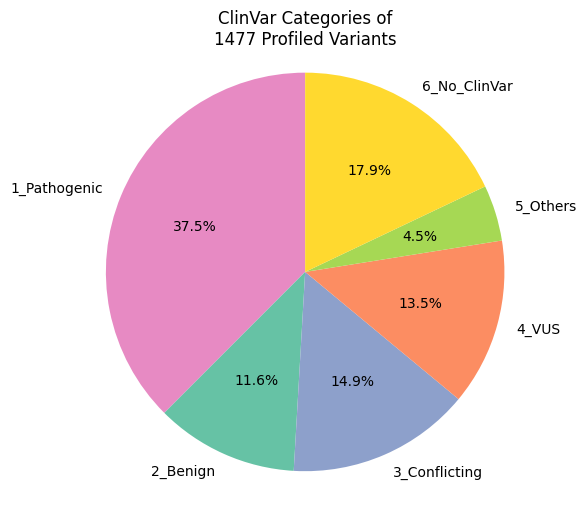

In [9]:
profiled_variants_df_clinvar = profiled_variants_pass_qc_df.join(
    clin_var_scores.select(
        pl.col(["allele_0","plddt","rsa","clinvar_clnsig_clean","clinvar_clnsig_clean_old"])
    ), 
    left_on="gene_allele", right_on="allele_0", how="left"
).filter(
    (pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol")) 
).with_columns(
    pl.col("clinvar_clnsig_clean").fill_null("6_No_ClinVar"),
    pl.col("clinvar_clnsig_clean_old").fill_null("6_No_ClinVar")
).unique(subset="gene_allele") ## get the unique alleles only

df = profiled_variants_df_clinvar.to_pandas()
df["symbol"] = df["gene_allele"].apply(lambda x: x.split("_")[0])

# Count category frequencies
counts = df["clinvar_clnsig_clean_old"].value_counts()

# Sort categories if you want specific order
category_order = sorted(df["clinvar_clnsig_clean_old"].unique())
counts = counts.reindex([cat for cat in category_order if cat in counts.index])

# Plot pie chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=clinvar_palette_old
)
ax.set_title(f"ClinVar Categories of\n{profiled_variants_df_clinvar.shape[0]} Profiled Variants",y=.94)
plt.tight_layout()
plt.show()

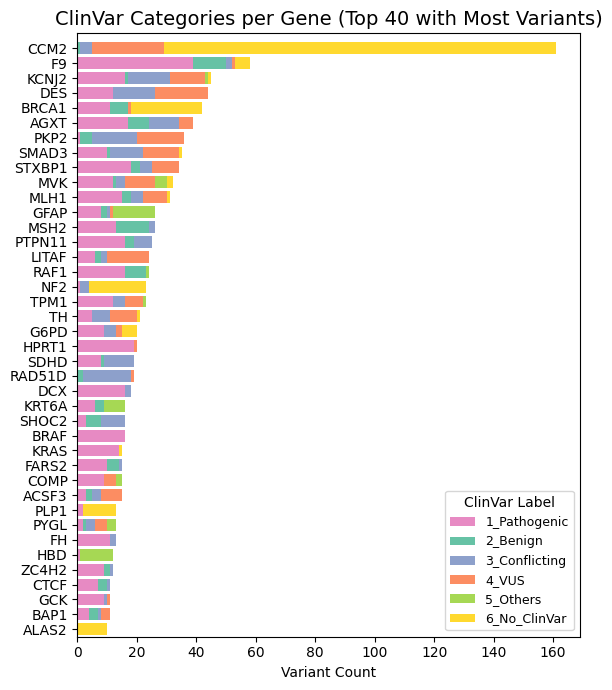

In [10]:
# 2. Count per (gene, category)
top_num = 40
counts = (
    df.groupby(["symbol", "clinvar_clnsig_clean_old"])
    .size()
    .reset_index(name="count")
)
# 3. Pivot
pivot = counts.pivot(index="symbol", columns="clinvar_clnsig_clean_old", values="count").fillna(0)

# Add total count column and sort by it (descending)
pivot["total_count"] = pivot.sum(axis=1)
pivot = pivot.sort_values("total_count", ascending=False).head(top_num)
pivot = pivot.drop(columns=["total_count"])

# 4. Ensure category order
for cat in category_order:
    if cat not in pivot.columns:
        pivot[cat] = 0
pivot = pivot[category_order]

# 5. Plotting
fig, ax = plt.subplots(figsize=(6, 7))
# Get Set2 colors
bottom = None
for cat, color in zip(category_order, clinvar_palette_old):
    ax.barh(pivot.index, pivot[cat], left=bottom, label=cat, color=color)
    bottom = pivot[cat] if bottom is None else bottom + pivot[cat]
# Axis formatting
ax.set_xlabel("Variant Count")
ax.set_ylim(-1, pivot.shape[0] - .5)  # Tighten y-axis to remove top/bottom gaps
ax.set_title(f"ClinVar Categories per Gene (Top {top_num} with Most Variants)", fontsize=14)
ax.invert_yaxis()
ax.legend(title="ClinVar Label", fontsize=9, title_fontsize=10, loc="lower right")
plt.tight_layout()
plt.show()

### 1.3 Called hits

In [11]:
# pl.Config.set_tbl_rows(20)  # Sets the number of rows displayed
print(profiled_variants_pass_qc_df.filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).unique(subset="gene_allele").shape)
print(profiled_variants_pass_qc_df.filter((pl.col("node_type")!="disease_wt") & (pl.col("gene_allele")!=pl.col("symbol"))).unique(subset="symbol").shape)

display(change_wtvar["localization"].unique(subset="allele_0"))
# change_wtvar["localization"].filter((pl.col("allele_0").str.contains("FARS2"))).sort(by="AUROC_Mean", descending=True) #(pl.col(f"Altered_local_both_batches"))
display(change_wtvar["localization"].filter(pl.col("Altered_local_both_batches")).sort(by=["allele_0","AUROC_Mean"]).unique(subset="allele_0"))
display(change_wtvar["localization"].with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene")
).sort(by=["allele_0","AUROC_Mean"]).unique(subset="gene"))

change_wtvar["localization"].filter(pl.col("Altered_local_both_batches")).with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene")
).sort(by=["allele_0","AUROC_Mean"]).unique(subset="gene")

(1477, 33)
(182, 33)


shape: (1_273, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_l ┆ Altered_l ┆ Altered_l ┆ … ┆ Altered_l ┆ Altered_l ┆ AUROC_bat ┆ AUROC_ba │
│ ---       ┆ ocal_batc ┆ ocal_batc ┆ ocal_both ┆   ┆ ocal_batc ┆ ocal_batc ┆ ch16      ┆ tch15    │
│ str       ┆ h8        ┆ h7        ┆ _batches  ┆   ┆ h16       ┆ h15       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ BRCA1_Ala ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 102Gly    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ SDHD_Leu1 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 39Arg     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ala1 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 79Ser     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ FKBP6_Arg ┆ null      ┆ null      ┆ false     ┆ … ┆ 1         ┆ 0         ┆ 0.840987  ┆ 0.829213 │
│ 202His    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRIP1_His ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 587Arg    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ GSS_Arg28 ┆ 0         ┆ 1         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 3Cys      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ PHYH_Gly2 ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.761114  ┆ 0.676353 │
│ 04Ser     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ LDHB_Trp3 ┆ 0         ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 25Arg     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ TMEM43_Ar ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.576634  ┆ 0.580295 │
│ g220Cys   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ala1 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 40Thr     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

shape: (279, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_l ┆ Altered_l ┆ Altered_l ┆ … ┆ Altered_l ┆ Altered_l ┆ AUROC_bat ┆ AUROC_ba │
│ ---       ┆ ocal_batc ┆ ocal_batc ┆ ocal_both ┆   ┆ ocal_batc ┆ ocal_batc ┆ ch16      ┆ tch15    │
│ str       ┆ h8        ┆ h7        ┆ _batches  ┆   ┆ h16       ┆ h15       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ DCX_Ser12 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 9Leu      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ AGXT_Asp2 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 01Asn     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ GFAP_Asp2 ┆ null      ┆ null      ┆ true      ┆ … ┆ 1         ┆ 1         ┆ 0.97713   ┆ 0.972929 │
│ 95Asn     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ LITAF_Val ┆ null      ┆ null      ┆ true      ┆ … ┆ 1         ┆ 1         ┆ 0.942727  ┆ 0.952243 │
│ 144Met    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ SFTPC_Leu ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 188Gln    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ DES_Leu13 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 6Pro      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ PLA2G6_Ar ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ g538Cys   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Arg ┆ null      ┆ null      ┆ true      ┆ … ┆ 1         ┆ 1         ┆ 0.912324  ┆ 0.868489 │
│ 312His    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_Ly ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ s196Arg   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_As ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ p207Asn   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

shape: (162, 20)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ allele_0   ┆ Altered_lo ┆ Altered_l ┆ Altered_l ┆ … ┆ Altered_l ┆ AUROC_bat ┆ AUROC_bat ┆ gene   │
│ ---        ┆ cal_batch8 ┆ ocal_batc ┆ ocal_both ┆   ┆ ocal_batc ┆ ch16      ┆ ch15      ┆ ---    │
│ str        ┆ ---        ┆ h7        ┆ _batches  ┆   ┆ h15       ┆ ---       ┆ ---       ┆ str    │
│            ┆ i64        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ f64       ┆        │
│            ┆            ┆ i64       ┆ bool      ┆   ┆ i64       ┆           ┆           ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ CCBE1_Gly1 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.790456  ┆ 0.6158    ┆ CCBE1  │
│ 36Arg      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ CLDN19_Arg ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.671792  ┆ 0.642595  ┆ CLDN19 │
│ 200Gln     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ PLA2G6_Arg ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ PLA2G6 │
│ 538Cys     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ EIF2B4_Ala ┆ 0          ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ EIF2B4 │
│ 391Asp     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ KLHL3_Ala7 ┆ 0          ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ KLHL3  │
│ 7Glu       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ …          ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …      │
│ RP2_Arg118 ┆ 0          ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ RP2    │
│ His        ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ CTH_Gln240 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.70599   ┆ 0.638952  ┆ CTH    │
│ Glu        ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ FANCC_Asp1 ┆ null       ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ FANCC  │
│ 95Val      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ MAP2K2_Thr ┆ 0          ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ MAP2K2 │
│ 17Ala      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ WRAP53_Arg ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ WRAP53 │
│ 398Trp     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴────────┘

shape: (74, 20)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ allele_0   ┆ Altered_lo ┆ Altered_l ┆ Altered_l ┆ … ┆ Altered_l ┆ AUROC_bat ┆ AUROC_bat ┆ gene   │
│ ---        ┆ cal_batch8 ┆ ocal_batc ┆ ocal_both ┆   ┆ ocal_batc ┆ ch16      ┆ ch15      ┆ ---    │
│ str        ┆ ---        ┆ h7        ┆ _batches  ┆   ┆ h15       ┆ ---       ┆ ---       ┆ str    │
│            ┆ i64        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ f64       ┆        │
│            ┆            ┆ i64       ┆ bool      ┆   ┆ i64       ┆           ┆           ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ FH_Ala308T ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ FH     │
│ hr         ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ ASNS_Ala6G ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ ASNS   │
│ lu         ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ DES_Ala337 ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ DES    │
│ Pro        ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ CCM2_Arg42 ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ CCM2   │
│ 3Pro       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ COMP_Asn52 ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ COMP   │
│ 3Lys       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ …          ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …      │
│ CRADD_Gly1 ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ CRADD  │
│ 28Arg      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ MVK_Asn301 ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ MVK    │
│ Thr        ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ TPM1_Asn27 ┆ null       ┆ null      ┆ true      ┆ … ┆ 1         ┆ 0.977159  ┆ 0.962467  ┆ TPM1   │
│ 9His       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ ZC4H2_Leu6 ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ ZC4H2  │
│ 6His       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ STXBP1_Arg ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ STXBP1 │
│ 190Gln     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴────────┘

In [12]:
74/162, 279/1273

(0.4567901234567901, 0.21916732128829536)

In [13]:
print(profiled_variants_pass_qc_df.filter((~pl.col("plate_map_name").str.contains("B7A"))&(~pl.col("plate_map_name").str.contains("B8A"))&\
                                    (pl.col("node_type")!="disease_wt")&(pl.col("gene_allele")!=pl.col("symbol"))).unique(subset="gene_allele").shape)
print(profiled_variants_pass_qc_df.filter((~pl.col("plate_map_name").str.contains("B7A"))&(~pl.col("plate_map_name").str.contains("B8A"))&\
                                    (pl.col("node_type")!="disease_wt")&(pl.col("gene_allele")!=pl.col("symbol"))).unique(subset="symbol").shape)
display(change_wtvar["morphology"].unique(subset="allele_0"))
display(change_wtvar["morphology"].filter(pl.col(f"Altered_morph_both_batches")).sort(by=["allele_0","AUROC_Mean"]).unique(subset="allele_0"))
display(change_wtvar["morphology"].with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene")
).sort(by=["allele_0","AUROC_Mean"]).unique(subset="gene"))
change_wtvar["morphology"].filter(pl.col("Altered_morph_both_batches")).with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene")
).sort(by=["allele_0","AUROC_Mean"]).unique(subset="gene")

(889, 33)
(71, 33)


shape: (730, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_m ┆ Altered_m ┆ Altered_m ┆ … ┆ Altered_m ┆ Altered_m ┆ AUROC_bat ┆ AUROC_ba │
│ ---       ┆ orph_batc ┆ orph_batc ┆ orph_both ┆   ┆ orph_batc ┆ orph_batc ┆ ch16      ┆ tch15    │
│ str       ┆ h12       ┆ h11       ┆ _batches  ┆   ┆ h16       ┆ h15       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ F9_Ile7Ph ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ e         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Pro1 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 02Ser     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Gly1 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 88Trp     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CCM2_Ile4 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 32Phe     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ F9_Asp410 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ His       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ MLH1_Ala1 ┆ 0         ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 60Val     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRIP1_Thr ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 266Lys    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_Gl ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ y544Asp   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ LITAF_Thr ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.798398  ┆ 0.710554 │
│ 49Met     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ F9_Ile136 ┆ null      ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ Thr       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

shape: (20, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_m ┆ Altered_m ┆ Altered_m ┆ … ┆ Altered_m ┆ Altered_m ┆ AUROC_bat ┆ AUROC_ba │
│ ---       ┆ orph_batc ┆ orph_batc ┆ orph_both ┆   ┆ orph_batc ┆ orph_batc ┆ ch16      ┆ tch15    │
│ str       ┆ h12       ┆ h11       ┆ _batches  ┆   ┆ h16       ┆ h15       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ STXBP1_Ar ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ g406Cys   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Phe ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 558Ser    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_His ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 239Arg    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_Pr ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ o335Leu   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Ser ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 611Arg    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ BRCA1_Arg ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 71Lys     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Pro ┆ null      ┆ null      ┆ true      ┆ … ┆ 1         ┆ 1         ┆ 0.962857  ┆ 0.977871 │
│ 420Leu    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRAF_Val4 ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 71Phe     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_As ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ p207Asn   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ IMPDH1_Ar ┆ null      ┆ null      ┆ true      ┆ … ┆ 1         ┆ 1         ┆ 0.966749  ┆ 0.976129 │
│ g273Pro   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

shape: (59, 16)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ allele_0   ┆ Altered_mo ┆ Altered_m ┆ Altered_m ┆ … ┆ Altered_m ┆ AUROC_bat ┆ AUROC_bat ┆ gene   │
│ ---        ┆ rph_batch1 ┆ orph_batc ┆ orph_both ┆   ┆ orph_batc ┆ ch16      ┆ ch15      ┆ ---    │
│ str        ┆ 2          ┆ h11       ┆ _batches  ┆   ┆ h15       ┆ ---       ┆ ---       ┆ str    │
│            ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ f64       ┆        │
│            ┆ i64        ┆ i64       ┆ bool      ┆   ┆ i64       ┆           ┆           ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ SDHD_Ala90 ┆ null       ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ SDHD   │
│ Glu        ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ KCNJ2_Ala7 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.927298  ┆ 0.929644  ┆ KCNJ2  │
│ 0Ser       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ HPRT1_His2 ┆ 0          ┆ 0         ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ HPRT1  │
│ 04Asp      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ FOXP3_Gln7 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ null      ┆ 0.822752  ┆ FOXP3  │
│ 0His       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ SFTPA2_Gln ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.547419  ┆ 0.699661  ┆ SFTPA2 │
│ 223Lys     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ …          ┆ …          ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …      │
│ SMAD3_Arg2 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.495923  ┆ 0.437308  ┆ SMAD3  │
│ 68Cys      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ RPS19_Arg1 ┆ null       ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ RPS19  │
│ 01His      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ GFAP_Ala36 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.85026   ┆ 0.646193  ┆ GFAP   │
│ 4Pro       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ FARS2_Ala1 ┆ null       ┆ null      ┆ false     ┆ … ┆ null      ┆ null      ┆ null      ┆ FARS2  │
│ 66Thr      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ COQ8A_Gly2 ┆ null       ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0.908794  ┆ 0.945211  ┆ COQ8A  │
│ 72Asp      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴────────┘

shape: (5, 16)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ allele_0   ┆ Altered_mo ┆ Altered_m ┆ Altered_m ┆ … ┆ Altered_m ┆ AUROC_bat ┆ AUROC_bat ┆ gene   │
│ ---        ┆ rph_batch1 ┆ orph_batc ┆ orph_both ┆   ┆ orph_batc ┆ ch16      ┆ ch15      ┆ ---    │
│ str        ┆ 2          ┆ h11       ┆ _batches  ┆   ┆ h15       ┆ ---       ┆ ---       ┆ str    │
│            ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ f64       ┆        │
│            ┆ i64        ┆ i64       ┆ bool      ┆   ┆ i64       ┆           ┆           ┆        │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ BRCA1_Arg7 ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ BRCA1  │
│ 1Lys       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ KCNJ2_Pro4 ┆ null       ┆ null      ┆ true      ┆ … ┆ 1         ┆ 0.962857  ┆ 0.977871  ┆ KCNJ2  │
│ 20Leu      ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ STXBP1_Arg ┆ 1          ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ STXBP1 │
│ 406Cys     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ IMPDH1_Arg ┆ null       ┆ null      ┆ true      ┆ … ┆ 1         ┆ 0.966749  ┆ 0.976129  ┆ IMPDH1 │
│ 273Pro     ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
│ BRAF_Gly59 ┆ null       ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ BRAF   │
│ 6Val       ┆            ┆           ┆           ┆   ┆           ┆           ┆           ┆        │
└────────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴────────┘

In [14]:
5/59, 20/730

(0.0847457627118644, 0.0273972602739726)

<Figure size 640x480 with 0 Axes>

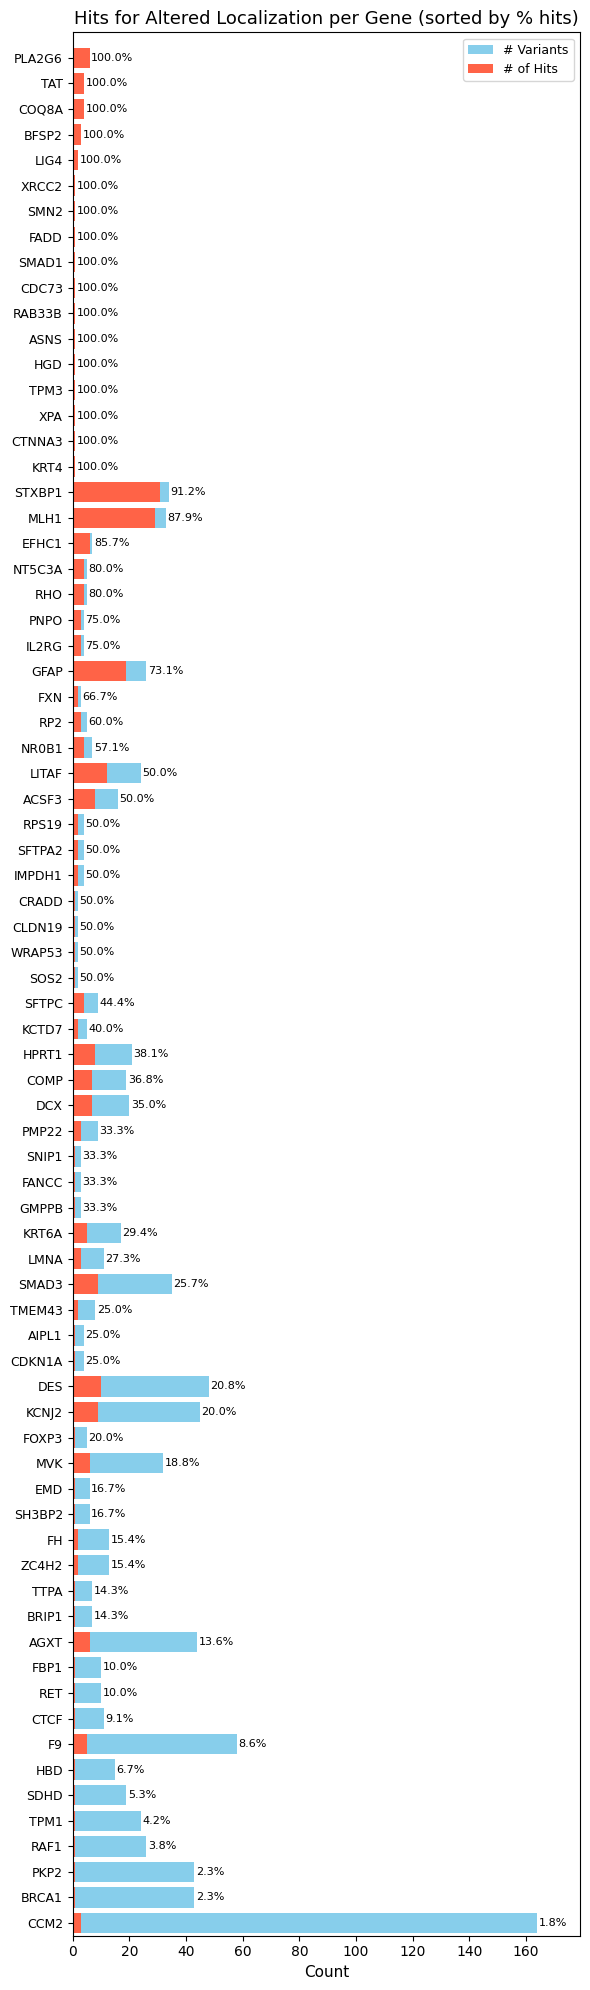

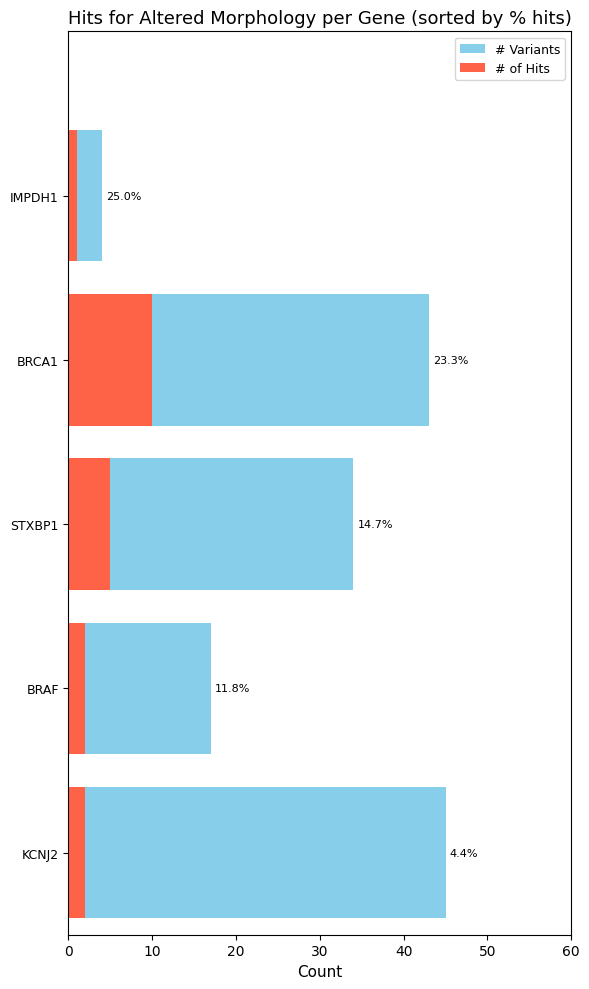

In [15]:
# import plotly.express as px
# def interactive_gene_summary_barplot(df, cell_change):
#     df = df.copy()
#     df["pct_hits"] = df["len_hits"] / df["len"] * 100
#     df = df.sort_values(by=["len", "pct_hits"], ascending=False).reset_index(drop=True)

#     fig = px.bar(
#         df,
#         x="len",
#         y="by",
#         orientation="h",
#         color="len_hits",
#         hover_data=["len", "len_hits", "pct_hits"],
#         color_continuous_scale="RdBu",
#         labels={"by": "Gene", "len": "Total Variants", "len_hits": "Hits"},
#         title=f"Altered {cell_change.capitalize()} Hits per Gene (Interactive)"
#     )
#     fig.update_layout(
#         yaxis=dict(autorange="reversed"),
#         height=max(800, len(df)*10),
#         margin=dict(l=120, r=20, t=40, b=20),
#     )
#     fig.show()


def plot_gene_level_summary_horizontal(total_allele_hit_sum_df, cell_change):
    # 1. Fill nulls with 0
    total_allele_hit_sum_df["len_hits"] = total_allele_hit_sum_df["len_hits"].fillna(0).astype(int)

    # 2. Compute percentage of hits
    total_allele_hit_sum_df["pct_hits"] = (
        total_allele_hit_sum_df["len_hits"] / total_allele_hit_sum_df["len"] * 100
    )

    # 3. Sort by percentage descending
    total_allele_hit_sum_df = total_allele_hit_sum_df.sort_values(
        by=["pct_hits","len"], ascending=False
    ).reset_index(drop=True)

    # 4. Keep the hits gene only
    total_allele_hit_sum_df = total_allele_hit_sum_df[total_allele_hit_sum_df["pct_hits"]>0] #.reset_index(drop=True)
    # display(total_allele_hit_sum_df)
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_height = 0.5
    fig_height = max(10, min(n_genes * bar_height, 20))  # cap to prevent overgrowth
    fig_width = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Horizontal bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percent
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            va="center",
            ha="left",
            fontsize=8,
        )

    # Axis formatting
    ax.set_yticks(y)
    ax.set_xlim(None, max(total_allele_hit_sum_df["len"]+15))  # Tighten y-axis to remove top/bottom gaps
    ax.set_ylim(-1, len(y) - .5)  # Tighten y-axis to remove top/bottom gaps
    ax.set_yticklabels(total_allele_hit_sum_df["by"], fontsize=9)
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"Hits for Altered {cell_change.capitalize()} per Gene (sorted by % hits)",
        fontsize=13
    )
    ax.invert_yaxis()  # Highest hit on top
    ax.legend(fontsize=9, loc="upper right")
    # Improve spacing
    plt.tight_layout()
    plt.show()

plt.clf()
for cell_change in CELL_CHANGES:
    total_allele_hit_sum_df = profiled_variants_df.filter(pl.col("node_type")=="allele").unique(subset="gene_allele").group_by(by="symbol").len().sort(by="len", descending=True).join(
        change_wtvar[cell_change].filter(pl.col(f"Altered_{cell_change[:5]}_both_batches")).with_columns(
            pl.col("allele_0").str.extract(r"^([^_]+)", 1).alias("symbol")
        ).group_by(by="symbol").len().sort(by="len", descending=True), on="by", suffix="_hits", how="left"
    ).to_pandas()
    plot_gene_level_summary_horizontal(total_allele_hit_sum_df, cell_change)

<Figure size 640x480 with 0 Axes>

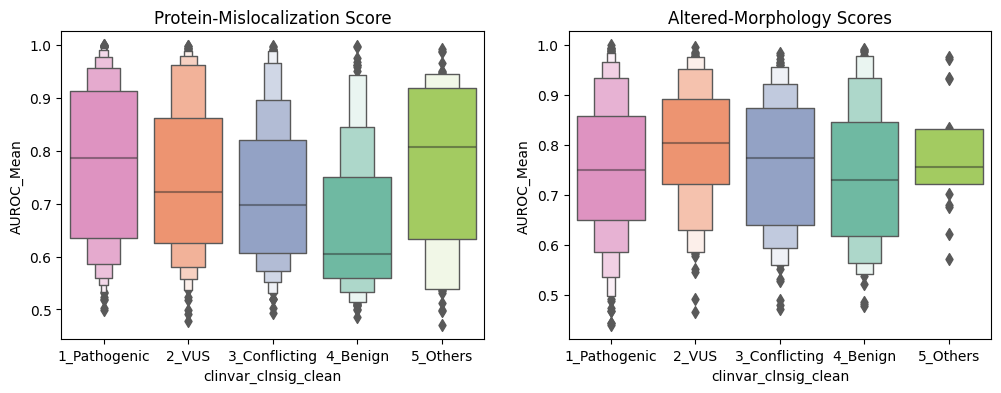

In [16]:
plt.clf()
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.boxenplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.8, ax=axes[0],
              palette=clinvar_palette[:-1],
              order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
# sns.swarmplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes[0],
#               palette=clinvar_palette[:-1],
#               order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
axes[0].set_title("Protein-Mislocalization Score")
sns.boxenplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.8, ax=axes[1],
              palette=clinvar_palette[:-1],
              order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
# sns.swarmplot(data=change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas(), x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes[1],
#               palette=clinvar_palette[:-1],
#               order=sorted(change_wtvar["morphology"].join(clin_var_scores, on="allele_0").to_pandas()["clinvar_clnsig_clean"].unique()))
axes[1].set_title("Altered-Morphology Scores")
plt.show()

In [17]:
# change_wtvar["localization"].filter((pl.col("allele_0").str.contains("STXBP1"))).sort(by="AUROC_Mean", descending=True) #(pl.col(f"Altered_local_both_batches"))
# change_wtvar["localization"].filter((pl.col("allele_0").str.contains("MLH1"))).sort(by="AUROC_Mean", descending=True) #(pl.col(f"Altered_local_both_batches"))

## 2. Loading cell profiles

In [18]:
BATCH_LIST_DICT = {
    "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
    "2024_02_06_Batch_8": "2024_02_Batch_7-8",
    "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
    "2024_12_09_Batch_12": "2024_12_Batch_11-12",
    "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
    "2025_01_28_Batch_14": "2025_01_Batch_13-14",
    "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
    "2025_03_17_Batch_16": "2025_03_Batch_15-16"
}

In [19]:
# Paths
pass_qc_prof_pq_path = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
ref_var_cell_qc_profile_df = pl.DataFrame()

# Get meta features
for batch_id in BATCH_LIST_DICT.keys():
    batch_alleles = (
        pl.scan_parquet(
            pass_qc_prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(profiled_variants_pass_qc_df["gene_allele"].unique()))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
        .select([
            "Metadata_CellID",
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
            "Metadata_node_type"
        ])
    )
    ref_var_cell_qc_profile_df = pl.concat([ref_var_cell_qc_profile_df, batch_alleles.collect()])

In [20]:
# Paths
prof_pq_path = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
ref_var_cell_all_profiles = {}

# Get meta features
for batch_id in BATCH_LIST_DICT.keys():
    batch_alleles = (
        pl.scan_parquet(
            prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(profiled_variants_pass_qc_df["gene_allele"].unique()))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
    )
    ref_var_cell_all_profiles[batch_id] = batch_alleles

In [144]:
gfp_feats = [i for i in list(ref_var_cell_all_profiles.values())[0].collect_schema() if "GFP" in i and "Brightfield" not in i]
gfp_feats = ["Metadata_CellID"] + gfp_feats

ref_var_cell_all_gfp_profiles_df = pl.concat([batch_alleles[1].select(gfp_feats).collect() for batch_alleles in ref_var_cell_all_profiles.items()])
# This method of joining ensures that only cells past filters are included in the abundance analysis
ref_var_cell_gfp_profile_df = ref_var_cell_qc_profile_df.join(ref_var_cell_all_gfp_profiles_df, on="Metadata_CellID", how="left")

morph_feats = [i for i in list(ref_var_cell_all_profiles.values())[2].collect_schema() if ("DNA" in i or "Mito" in i or "AGP" in i) and "Brightfield" not in i]
morph_feats = ["Metadata_CellID"] + morph_feats

ref_var_cell_all_morph_profiles_df = pl.concat([batch_alleles[1].select(morph_feats).collect() for batch_alleles in ref_var_cell_all_profiles.items() if "Batch_7" not in batch_alleles[0] and "Batch_8" not in batch_alleles[0]])
# This method of joining ensures that only cells past filters are included in the abundance analysis
ref_var_cell_morph_profile_df = ref_var_cell_qc_profile_df.join(ref_var_cell_all_morph_profiles_df, on="Metadata_CellID", how="inner")

In [238]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import rankdata, norm


def inverse_normal_transform(x):
    ranks = rankdata(x, method="average")
    return norm.ppf((ranks - 0.5) / len(ranks))


# Define INT function for a single column
def inverse_normal_transform_series(series: pl.Series) -> pl.Series:
    values = series #.to_numpy()
    ranks = rankdata(values, method="average")
    n = len(ranks)
    transformed = norm.ppf((ranks - 0.5) / n)
    return pl.Series(series.name, transformed)


def int_num_cols(df):
    # 2) pick the columns you want to INT (here all numeric columns)
    num_cols = [
        name
        for name, dtype in df.schema.items()
        if "Metadata_" not in name
    ]

    # 3) for each numeric column, pull out a numpy array, compute the INT, and wrap back
    transforms = []
    for col in num_cols:
        arr = df[col].to_numpy()
        ranks = rankdata(arr, method="average")
        quantiles = (ranks - 0.5) / len(arr)
        transformed = norm.ppf(quantiles)
        transforms.append(pl.Series(col, transformed))

    # 4) build a new DataFrame of the transformed columns
    df_int = pl.DataFrame(transforms)
    # print(df_int)

    # 5) you can then concat non-numeric columns back if needed:
    non_num = df.select(pl.exclude(num_cols))
    df_norm = non_num.hstack(df_int)
    return df_norm
    

def remove_corr_feats(df, corr_thres=.8):
    # 2. Identify numeric columns
    all_num_feats = [
        name
        for name, dtype in df.schema.items()
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    ]
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)

    return df_drop_corr_cols


def plot_dr(df, dr_method, standardize=True, ax=None, dr_args={}, plot_args={}):
    df_val = df.select(pl.col([col for col in df.columns if not col.startswith("Metadata_")]))#.drop_nulls()
    if standardize:
        # Standardize the features before PCA
        scaler = StandardScaler()
        df_val = pd.DataFrame(scaler.fit_transform(df_val), columns=df_val.columns)

    if dr_method=="pca":
        pca = PCA(**dr_args) #n_components=10
        dr_result = pca.fit_transform(df_val)
    if dr_method=="umap":
        # Perform UMAP
        umap_model = umap.UMAP(**dr_args) ## n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1
        dr_result = umap_model.fit_transform(df_val.to_numpy())

    dr_res_df = pd.DataFrame(dr_result, columns=[f"Comp{i+1}" for i in range(dr_result.shape[1])])
    for key in ["hue", "style", "size"]:
        if key in plot_args and plot_args[key] in df.columns:
            dr_res_df[plot_args[key]] = df[plot_args[key]].to_numpy()

    if ax is None:
        # Plot UMAP
        fig, ax = plt.subplots(1, 1, figsize=(6, 7))

    # print(len(dr_res_df[plot_args["hue"]].unique()))
    if "palette" not in plot_args:
        sns.scatterplot(data=dr_res_df.sort_values(by=plot_args["hue"]),
                        x="Comp1", y="Comp2",
                        palette=sns.color_palette("husl", len(dr_res_df.dropna(subset=plot_args["hue"])[plot_args["hue"]].unique())),#, 
                        ax=ax, **plot_args) ##  alpha=.5, s=40
    else:
        sns.scatterplot(data=dr_res_df.sort_values(by=plot_args["hue"]),
                        x="Comp1", y="Comp2",
                        ax=ax, **plot_args) ##  alpha=.5, s=40
    # plt.show()
    # ax[1].legend(ncol=2, title="Metadata_Batch")
    return dr_res_df

In [25]:
print(ref_var_cell_morph_profile_df.shape)
print(ref_var_cell_gfp_profile_df.shape)

(4919381, 2192)
(4919381, 764)


### 2.1 Aggregate to well-level

In [23]:
ref_var_well_gfp_profile_df = (
    ref_var_cell_gfp_profile_df.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in ref_var_cell_gfp_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

ref_var_well_gfp_profile_df = ref_var_well_gfp_profile_df.with_columns(
    pl.col("Metadata_Plate")
      # capture a “B” followed by any non-underscore chars up to the first “A”
      .str.extract(r"(B[^_]*?A)", 1)
      .alias("Metadata_Batch")
).drop_nulls()

ref_var_well_gfp_profile_df = remove_corr_feats(ref_var_well_gfp_profile_df)
ref_var_well_gfp_profile_df

shape: (17_354, 71)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Metadata_ ┆ Metadata_ ┆ Metadata_ ┆ Cytoplasm ┆ … ┆ Nuclei_Lo ┆ Nuclei_Lo ┆ Nuclei_Te ┆ Metadata │
│ Plate     ┆ Well      ┆ gene_alle ┆ _Correlat ┆   ┆ cation_Ce ┆ cation_Ma ┆ xture_Cor ┆ _Batch   │
│ ---       ┆ ---       ┆ le        ┆ ion_Corre ┆   ┆ nterMassI ┆ xIntensit ┆ relation_ ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ lat…      ┆   ┆ nte…      ┆ y_Z…      ┆ GFP…      ┆ str      │
│           ┆           ┆ str       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆          │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-03-1 ┆ E04       ┆ IMPDH1_As ┆ 0.275772  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.007874 ┆ B16A     │
│ 7_B16A1A2 ┆           ┆ p275Asn   ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ B01       ┆ MSRB3_Cys ┆ 0.255681  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ B16A     │
│ 7_B16A1A2 ┆           ┆ 82Gly     ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_3 ┆ O17       ┆ AGXT_Pro3 ┆ 0.020576  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ B8A      │
│ 1_B8A1R2_ ┆           ┆ 19Leu     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P1T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025_01_2 ┆ O06       ┆ ZC4H2_Val ┆ 0.32672   ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.008916 ┆ B13A     │
│ 7_B13A7A8 ┆           ┆ 63Leu     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2_T2     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_3 ┆ H14       ┆ LDHB_Trp3 ┆ 0.105832  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.009458 ┆ B8A      │
│ 1_B8A1R2_ ┆           ┆ 25Arg     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2025_01_2 ┆ O02       ┆ SHOC2_Ser ┆ 0.444338  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ B13A     │
│ 7_B13A7A8 ┆           ┆ 403Gly    ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2_T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ E01       ┆ ACSF3_Thr ┆ 0.400675  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.003503 ┆ B7A      │
│ 7_B7A1R1_ ┆           ┆ 358Ile    ┆           ┆   ┆           ┆           ┆           ┆          │
│ P1T3      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ J05       ┆ COMP_His5 ┆ 0.217392  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.024453 ┆ B7A      │
│ 7_B7A1R1_ ┆           ┆ 87Arg     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P1T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ A16       ┆ KCNJ2_Arg ┆ 0.399084  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ B15A     │
│ 7_B15A1A2 ┆           ┆ 189Lys    ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T2     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ F14       ┆ RAB33B    ┆ 0.183885  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.024634  ┆ B7A      │
│ 9_B7A1R1_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ P3T3      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴────

In [24]:
ref_var_well_gfp_profile_df.filter(pl.col("Metadata_gene_allele").str.contains("GFAP"))

shape: (407, 71)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Metadata_ ┆ Metadata_ ┆ Metadata_ ┆ Cytoplasm ┆ … ┆ Nuclei_Lo ┆ Nuclei_Lo ┆ Nuclei_Te ┆ Metadata │
│ Plate     ┆ Well      ┆ gene_alle ┆ _Correlat ┆   ┆ cation_Ce ┆ cation_Ma ┆ xture_Cor ┆ _Batch   │
│ ---       ┆ ---       ┆ le        ┆ ion_Corre ┆   ┆ nterMassI ┆ xIntensit ┆ relation_ ┆ ---      │
│ str       ┆ str       ┆ ---       ┆ lat…      ┆   ┆ nte…      ┆ y_Z…      ┆ GFP…      ┆ str      │
│           ┆           ┆ str       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆          │
│           ┆           ┆           ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-03-1 ┆ O19       ┆ GFAP_Leu9 ┆ 0.061137  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.031653 ┆ B15A     │
│ 7_B15A1A2 ┆           ┆ 0Pro      ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T4     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ G21       ┆ GFAP_Arg2 ┆ 0.065692  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.0328   ┆ B15A     │
│ 7_B15A1A2 ┆           ┆ 39Leu     ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T4     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ K17       ┆ GFAP_Met7 ┆ 0.111199  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.020559 ┆ B16A     │
│ 7_B16A1A2 ┆           ┆ 4Thr      ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_3 ┆ E21       ┆ GFAP_Glu2 ┆ -0.08125  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.043606 ┆ B8A      │
│ 1_B8A1R2_ ┆           ┆ 07Lys     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ G19       ┆ GFAP_Arg2 ┆ 0.010918  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.019266 ┆ B15A     │
│ 7_B15A1A2 ┆           ┆ 39Pro     ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T3     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2025-03-1 ┆ I19       ┆ GFAP_Arg7 ┆ 0.03119   ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.026432 ┆ B15A     │
│ 7_B15A1A2 ┆           ┆ 9Cys      ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T3     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ E21       ┆ GFAP_Lys2 ┆ 0.100187  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.013109 ┆ B15A     │
│ 7_B15A1A2 ┆           ┆ 36Thr     ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T2     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ E21       ┆ GFAP_Glu2 ┆ -0.034605 ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.024412 ┆ B7A      │
│ 7_B7A1R1_ ┆           ┆ 07Lys     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2T3      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ M23       ┆ GFAP_Leu3 ┆ 0.354301  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ B7A      │
│ 7_B7A1R1_ ┆           ┆ 52Pro     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ A02       ┆ GFAP_Glu2 ┆ 0.152871  ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.047729 ┆ B7A      │
│ 7_B7A1R1_ ┆           ┆ 05Lys     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2T2      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────

In [28]:
ref_var_well_gfp_profile_int_df = int_num_cols(ref_var_well_gfp_profile_df)

## 3. Loading subcell compartment per gene

In [29]:
hpa_subcell_loc = pl.read_csv("/home/shenrunx/data_storage/igvf/varchamp/subcellular_localization/hpa_subcellular_location_annotations/subcellular_location_data.tsv", separator="\t")
hpa_subcell_loc = hpa_subcell_loc.with_columns(
    pl.when(pl.col("Main location").str.contains(";"))
    .then(pl.lit("Multiple"))
    .otherwise(pl.col("Main location"))
    .alias("Subcell_Loc")
)
hpa_subcell_loc_main = hpa_subcell_loc.filter(
    (pl.col("Subcell_Loc")!="Multiple")&(pl.col("Additional location").is_null()&(pl.col("Reliability")=="Approved"))
)

hpa_genes = hpa_subcell_loc["Gene name"]
# hpa_genes

# Read a JSON file into a pandas DataFrame
cd_code_json_file_path = "/home/shenrunx/data_storage/igvf/varchamp/subcellular_localization/cd-code/dataset.json"
cd_code_df = pd.read_json(cd_code_json_file_path)
# display(cd_code_df.head())
# 1. normalize into a new DataFrame
cell_compart_labels = pd.json_normalize(cd_code_df["labels"])#.dropna(how="all")
# display(cell_compart_labels)
## 2. drop the labels
cd_code_df = pd.concat([cd_code_df, cell_compart_labels], axis=1)
cd_code_df = cd_code_df.dropna(subset=["gene_names"]).drop(columns=["labels"])
cd_code_df = cd_code_df[cd_code_df["gene_names"]!=""]
cd_code_df.sort_values(by="gene_names")

gene_names         entry  \
1829         A3G  U5KJ79_HUMAN   
1238        AAAS    AAAS_HUMAN   
1272        AATF    AATF_HUMAN   
64         ABCC5    MRP5_HUMAN   
1275        ABI2    ABI2_HUMAN   
...          ...           ...   
2407      ZWILCH  H3BSG1_HUMAN   
168        ZWINT   ZWINT_HUMAN   
592          ZYX     ZYX_HUMAN   
2547  dJ402G11.9  Q6ICA1_HUMAN   
1764       hTERT  O94807_HUMAN   

                                               sequence  \
1829  MKPHFRNTVERMYRDTFSYNFYNRPILSRRNTVWLCYEVKTKGPSR...   
1238  MCSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPPPDFRGQWINLP...   
1272  MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGEDG...   
64    MKDIDIGKEYIIPSPGYRSVRERTSTSGTHRDREDSKFRRTRPLEC...   
1275  MAELQMLLEEEIPGGRRALFDSYTNLERVADYCENNYIQSADKQRA...   
...                                                 ...   
2407  MAHNPNMTHLKINLPVTALPPLWVRCDSSDPEGTCWLGAELITTNN...   
168   MEAAETEAEAAALEVLAEVAGILEPVGLQEEAELPAKILVEFVVDS...   
592   MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSEP...   
2547  MYVPALGWEFLASTRLTSELNFLLQEIDNCYHRAAEGRAPKIEKQI...   
1764  MPRAPRCRAVRSLLRSHYREVLPLATFVRRLGPQGWRLVQRGDPAA...   

                                                   idrs  split     FCR_SUM  \
1829                                        [PLDA, CQK]    dev   94.428571   
1238  [CSLGLFPPPPPRGQVTLYEHNNELVTGSSYESPP, DPLKTPGRL...  train   88.000000   
1272  [MAGPQPLALQLEQLLNPRPSEADPEADPEEATAARVIDRFDEGED...  train  195.714286   
64    [DIDIGKEYIIPSPGYRSVRERTSTSGTHRDREDSKFRRTRPLECQ...  train  314.571429   
1275  [QMLLE, RRALFDS, CENNYIQSADKQRALEETKAY, ASQLRR...  train   95.571429   
...                                                 ...    ...         ...   
2407                                     [MAHNPNMTHLKI]  train   14.000000   
168   [MEAAETEAEAA, AQEDTAKGLDPLASEDTSRQKAIAAKEQWKEL...  train   82.714286   
592   [MAAPRPSPAISVSVSAPAFYAPQKKFGPVVAPKPKVNPFRPGDSE...  train  103.285714   
2547  [EGRAPKIEKQIQSKGPGITEREKREIIENAEKEKSPEQNLFEK, ...  train  125.285714   
1764  [PEAFTTSVRSYLPN, QLGAATQARPPPHASGPRRRLGCERAWNH...  train  104.285714   

      FCR_MEAN      NCPR_SUM     NCPR_MEAN       ISO  ...  lysosome  \
1829  0.245908  5.857143e+00  1.525298e-02   8.31250  ...       0.0   
1238  0.161172  4.440892e-16  8.133502e-19   7.87500  ...       0.0   
1272  0.349490 -3.771429e+01 -6.734694e-02   4.59375  ...       0.0   
64    0.218908  1.628571e+01  1.133313e-02   8.75000  ...       0.0   
1275  0.186299 -5.571429e+00 -1.086048e-02   6.12500  ...       0.0   
...        ...           ...           ...       ...  ...       ...   
2407  0.166667  2.000000e+00  2.380952e-02   8.75000  ...       0.0   
168   0.298608 -8.714286e+00 -3.145952e-02   4.81250  ...       0.0   
592   0.180569 -6.714286e+00 -1.173826e-02   6.56250  ...       0.0   
2547  0.230729  8.714286e+00  1.604841e-02   8.75000  ...       0.0   
1764  0.199399  5.228571e+01  9.997269e-02  12.03125  ...       0.0   

      rna_granule  endoplasmic_reticulum  vesicles     nuclear_speckles pbody  \
1829          0.0                    0.0       0.0 NaN              NaN   NaN   
1238          0.0                    0.0       0.0 NaN              NaN   NaN   
1272          0.0                    0.0       0.0 NaN              NaN   NaN   
64            0.0                    0.0       0.0 NaN              NaN   NaN   
1275          0.0                    0.0       0.0 NaN              NaN   NaN   
...           ...                    ...       ...  ..              ...   ...   
2407          0.0                    0.0       0.0 NaN              NaN   NaN   
168           0.0                    0.0       0.0 NaN              NaN   NaN   
592           0.0                    0.0       0.0 NaN              NaN   NaN   
2547          0.0                    0.0       0.0 NaN              NaN   NaN   
1764          0.0                    0.0       0.0 NaN              NaN   NaN   

     pml_body post_synaptic_density transcriptional  
1829      NaN                   NaN             NaN  
1238      NaN    

In [30]:
ref_var_well_gfp_profile_df_hpa = ref_var_well_gfp_profile_int_df.join(
    hpa_subcell_loc_main.with_columns(
        pl.col("Gene name").alias("Metadata_genename_hpa"),
        pl.col("Subcell_Loc").alias("Metadata_Subcell_Loc"),
    ).select(pl.col(["Metadata_genename_hpa", "Metadata_Subcell_Loc"])), 
    left_on="Metadata_gene_allele", right_on="Metadata_genename_hpa",
    how="left"
)

ref_var_well_gfp_profile_df_hpa
# ref_var_well_gfp_profile_df_hpa.drop_nulls(subset="Metadata_Subcell_Loc")
# ref_allele_well_profile_df_hpa.filter(pl.col("Metadata_Plate").str.contains("B11"))

shape: (17_354, 72)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Metadata_ ┆ Metadata_ ┆ Metadata_ ┆ Metadata_ ┆ … ┆ Nuclei_Lo ┆ Nuclei_Lo ┆ Nuclei_Te ┆ Metadata │
│ Plate     ┆ Well      ┆ gene_alle ┆ Batch     ┆   ┆ cation_Ce ┆ cation_Ma ┆ xture_Cor ┆ _Subcell │
│ ---       ┆ ---       ┆ le        ┆ ---       ┆   ┆ nterMassI ┆ xIntensit ┆ relation_ ┆ _Loc     │
│ str       ┆ str       ┆ ---       ┆ str       ┆   ┆ nte…      ┆ y_Z…      ┆ GFP…      ┆ ---      │
│           ┆           ┆ str       ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-03-1 ┆ E04       ┆ IMPDH1_As ┆ B16A      ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.090326 ┆ null     │
│ 7_B16A1A2 ┆           ┆ p275Asn   ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ B01       ┆ MSRB3_Cys ┆ B16A      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.602577  ┆ null     │
│ 7_B16A1A2 ┆           ┆ 82Gly     ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_3 ┆ O17       ┆ AGXT_Pro3 ┆ B8A       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.602577  ┆ null     │
│ 1_B8A1R2_ ┆           ┆ 19Leu     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P1T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025_01_2 ┆ O06       ┆ ZC4H2_Val ┆ B13A      ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.11443  ┆ null     │
│ 7_B13A7A8 ┆           ┆ 63Leu     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2_T2     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_3 ┆ H14       ┆ LDHB_Trp3 ┆ B8A       ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.125487 ┆ null     │
│ 1_B8A1R2_ ┆           ┆ 25Arg     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2025_01_2 ┆ O02       ┆ SHOC2_Ser ┆ B13A      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.602577  ┆ null     │
│ 7_B13A7A8 ┆           ┆ 403Gly    ┆           ┆   ┆           ┆           ┆           ┆          │
│ P2_T1     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ E01       ┆ ACSF3_Thr ┆ B7A       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.034167  ┆ null     │
│ 7_B7A1R1_ ┆           ┆ 358Ile    ┆           ┆   ┆           ┆           ┆           ┆          │
│ P1T3      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ J05       ┆ COMP_His5 ┆ B7A       ┆ … ┆ 0.0       ┆ 0.0       ┆ -0.442989 ┆ null     │
│ 7_B7A1R1_ ┆           ┆ 87Arg     ┆           ┆   ┆           ┆           ┆           ┆          │
│ P1T1      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2025-03-1 ┆ A16       ┆ KCNJ2_Arg ┆ B15A      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.602577  ┆ null     │
│ 7_B15A1A2 ┆           ┆ 189Lys    ┆           ┆   ┆           ┆           ┆           ┆          │
│ _P1T2     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2024_01_1 ┆ F14       ┆ RAB33B    ┆ B7A       ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.254729  ┆ null     │
│ 9_B7A1R1_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ P3T3      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴────

<Figure size 640x480 with 0 Axes>

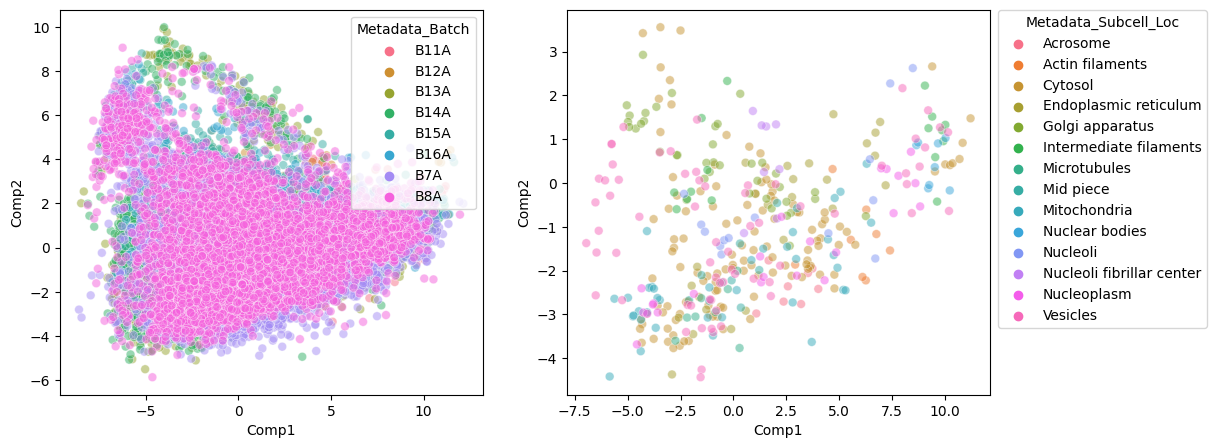

In [31]:
plt.clf()
fig, axes = plt.subplots(1,2,figsize=(12,5))
plot_dr(ref_var_well_gfp_profile_df_hpa, "pca", dr_args={"n_components": 10}, plot_args={"hue": "Metadata_Batch"}, ax=axes[0])
plot_dr(ref_var_well_gfp_profile_df_hpa, "pca", dr_args={"n_components": 10}, plot_args={"hue": "Metadata_Subcell_Loc"}, ax=axes[1])
ax=axes[1].legend(ncol=1, title="Metadata_Subcell_Loc",
             loc="upper left",
             bbox_to_anchor=(1.02, 1.0),
             borderaxespad=0)
plt.show()

In [32]:
ref_var_well_gfp_profile_hpa_values = ref_var_well_gfp_profile_df_hpa.select(pl.col([col for col in ref_var_well_gfp_profile_df_hpa.columns if not col.startswith("Metadata_")]))#.drop_nulls()
# Standardize the features before PCA
scaler = StandardScaler()
df_val = pd.DataFrame(scaler.fit_transform(ref_var_well_gfp_profile_hpa_values), columns=ref_var_well_gfp_profile_hpa_values.columns)

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1) ## 
dr_result = umap_model.fit_transform(df_val.to_numpy())
dr_res_df = pd.DataFrame(dr_result, columns=[f"Comp{i+1}" for i in range(dr_result.shape[1])])
dr_res_df["allele"] = ref_var_well_gfp_profile_df_hpa["Metadata_gene_allele"]
dr_res_df["Metadata_Batch"] = ref_var_well_gfp_profile_df_hpa["Metadata_Batch"]

<Figure size 640x480 with 0 Axes>

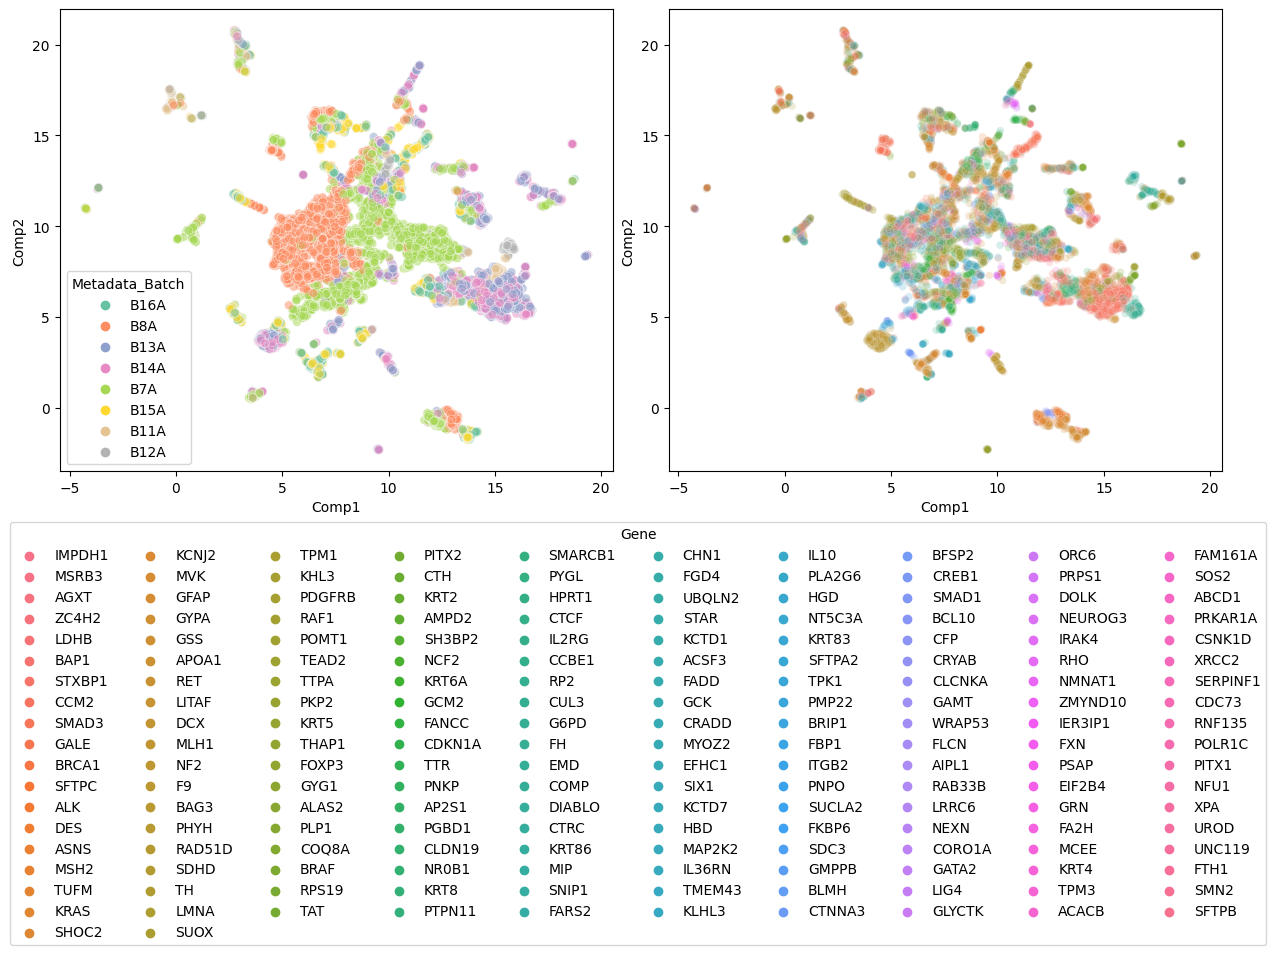

In [48]:
plt.clf()
dr_res_df["gene"] = dr_res_df["allele"].apply(lambda x: x.split("_")[0])
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=dr_res_df, alpha=.5, hue="Metadata_Batch",
                x="Comp1", y="Comp2", palette="Set2", s=40, ax=ax[0]) ## hue=variant_type, 
sns.scatterplot(data=dr_res_df[dr_res_df["allele"].str.contains("_")], 
                x="Comp1", y="Comp2", hue="gene", s=30, ax=ax[1], alpha=.2,
                palette=sns.color_palette("husl", len(dr_res_df[dr_res_df["allele"].str.contains("_")]["gene"].unique()))) ## hue=variant_type, 
# ax[1].get_legend().remove()
ax[1].legend(ncol=10, title="Gene",
             loc="upper right",
             bbox_to_anchor=(1.08, -.11),
             borderaxespad=0)
plt.subplots_adjust(wspace=0.1)
plt.show()

## 4. Localization

In [49]:
ref_var_allele_gfp_profile_df = (
    ref_var_cell_gfp_profile_df.group_by(["Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in ref_var_cell_gfp_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)
ref_var_allele_gfp_profile_corr_df = ref_var_allele_gfp_profile_df.select(["Metadata_gene_allele"]+[col for col in ref_var_allele_gfp_profile_df.columns if "Correlation_Correlation" in col])

In [50]:
ref_var_allele_gfp_profile_corr_df.describe()

shape: (9, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Metadata_ ┆ Cytoplasm ┆ Cytoplasm ┆ … ┆ Cells_Cor ┆ Nuclei_Co ┆ Nuclei_Co ┆ Nuclei_C │
│ ---       ┆ gene_alle ┆ _Correlat ┆ _Correlat ┆   ┆ relation_ ┆ rrelation ┆ rrelation ┆ orrelati │
│ str       ┆ le        ┆ ion_Corre ┆ ion_Corre ┆   ┆ Correlati ┆ _Correlat ┆ _Correlat ┆ on_Corre │
│           ┆ ---       ┆ lat…      ┆ lat…      ┆   ┆ on_…      ┆ ion…      ┆ ion…      ┆ lation…  │
│           ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 1797      ┆ 1797.0    ┆ 1797.0    ┆ … ┆ 1797.0    ┆ 1797.0    ┆ 1797.0    ┆ 1797.0   │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 0.271044  ┆ 0.260199  ┆ … ┆ 0.573932  ┆ 0.272346  ┆ -0.253257 ┆ 0.458046 │
│ std       ┆ null      ┆ 0.10324   ┆ 0.116542  ┆ … ┆ 0.166706  ┆ 0.235269  ┆ 0.404057  ┆ 0.246523 │
│ min       ┆ ABCD1     ┆ -0.026235 ┆ -0.063138 ┆ … ┆ -0.159181 ┆ -0.446121 ┆ -0.72258  ┆ -0.40369 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ 25%       ┆ null      ┆ 0.209077  ┆ 0.20066   ┆ … ┆ 0.486757  ┆ 0.161285  ┆ -0.561321 ┆ 0.389964 │
│ 50%       ┆ null      ┆ 0.282741  ┆ 0.235254  ┆ … ┆ 0.575386  ┆ 0.351549  ┆ -0.372334 ┆ 0.527045 │
│ 75%       ┆ null      ┆ 0.340904  ┆ 0.301311  ┆ … ┆ 0.681537  ┆ 0.444433  ┆ -0.141867 ┆ 0.61963  │
│ max       ┆ ZNF624    ┆ 0.641768  ┆ 0.834656  ┆ … ┆ 0.919429  ┆ 0.726878  ┆ 0.867684  ┆ 0.889132 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [51]:


misloc_variant_corr_diff_df = pd.DataFrame()
for misloc_gene in misloc_genes:
    # fig, axes = plt.subplots(1,1,figsize=(6,5))
    # sns.boxenplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # sns.swarmplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # axes.set_title(misloc_gene)

    ref_var_allele_gfp_profile_corr_df_gene = ref_var_allele_gfp_profile_corr_df.filter(pl.col("Metadata_gene_allele").str.contains(misloc_gene)).to_pandas()
    # print(misloc_gene)
    # display(ref_var_allele_gfp_profile_corr_df_gene)

    misloc_allele_profile_df_nocorr_wt = ref_var_allele_gfp_profile_corr_df_gene[~ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    misloc_allele_profile_df_nocorr_var = ref_var_allele_gfp_profile_corr_df_gene[ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].str.contains("_")].copy()
    misloc_allele_profile_df_nocorr_var = ref_var_allele_gfp_profile_corr_df_gene[(ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].str.contains("_"))&\
                                                                      ref_var_allele_gfp_profile_corr_df_gene["Metadata_gene_allele"].isin(
                                                                          change_wtvar["localization"].filter((pl.col(f"Altered_local_both_batches")))["allele_0"]
                                                                      )].copy()
    misloc_allele_profile_df_nocorr_var["Gene"] = misloc_allele_profile_df_nocorr_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

    misloc_allele_var_minus_wt = pd.DataFrame()
    try:
        for gene, group in misloc_allele_profile_df_nocorr_var.groupby("Gene"):
            # print(gene)
            # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
            group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
            g_col = group.columns
            # display(group)
            group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
            # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
            misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
            # display(misloc_allele_var_minus_wt)
    except:
        continue
    # display(misloc_allele_var_minus_wt)
    # print(misloc_allele_var_minus_wt.shape[0])
    # print(misloc_allele_var_minus_wt.shape[0])
    misloc_variant_corr_diff_df = pd.concat([misloc_variant_corr_diff_df, misloc_allele_var_minus_wt])

In [61]:
# ref_var_allele_gfp_profile_corr_df = ref_var_allele_gfp_profile_corr_df.filter(pl.col("Metadata_gene_allele").is_in(misloc_vars)).to_pandas()
# misloc_variant_corr_diff_df

<Figure size 640x480 with 0 Axes>

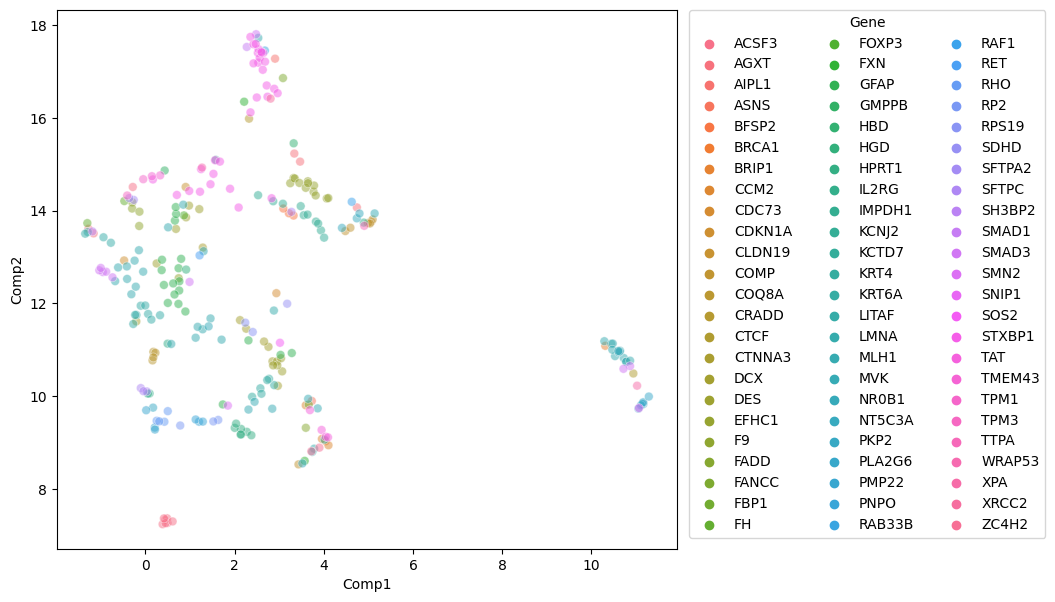

In [62]:
misloc_variant_corr_diff_df["Metadata_gene"] = [idx.split("_")[0] for idx in misloc_variant_corr_diff_df.index]
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8,7))
umap_misloc_var_corr_diff = plot_dr(pl.DataFrame(misloc_variant_corr_diff_df), "umap", plot_args={"hue": "Metadata_gene"}, ax=ax)
ax.legend(ncol=3, title="Gene",
             loc="upper left",
             bbox_to_anchor=(1.02, 1.0),
             borderaxespad=0)
plt.show()

In [64]:
# display(umap_misloc_var_corr_diff[umap_misloc_var_corr_diff["Comp1"]<(-2)])
# display(umap_misloc_var_corr_diff[umap_misloc_var_corr_diff["Comp1"]>10])
# display(umap_misloc_var_corr_diff[umap_misloc_var_corr_diff["Metadata_gene"].str.contains("RHO")])
# display(umap_misloc_var_corr_diff[umap_misloc_var_corr_diff["Metadata_gene"].str.contains("ACSF3")])

<Figure size 640x480 with 0 Axes>

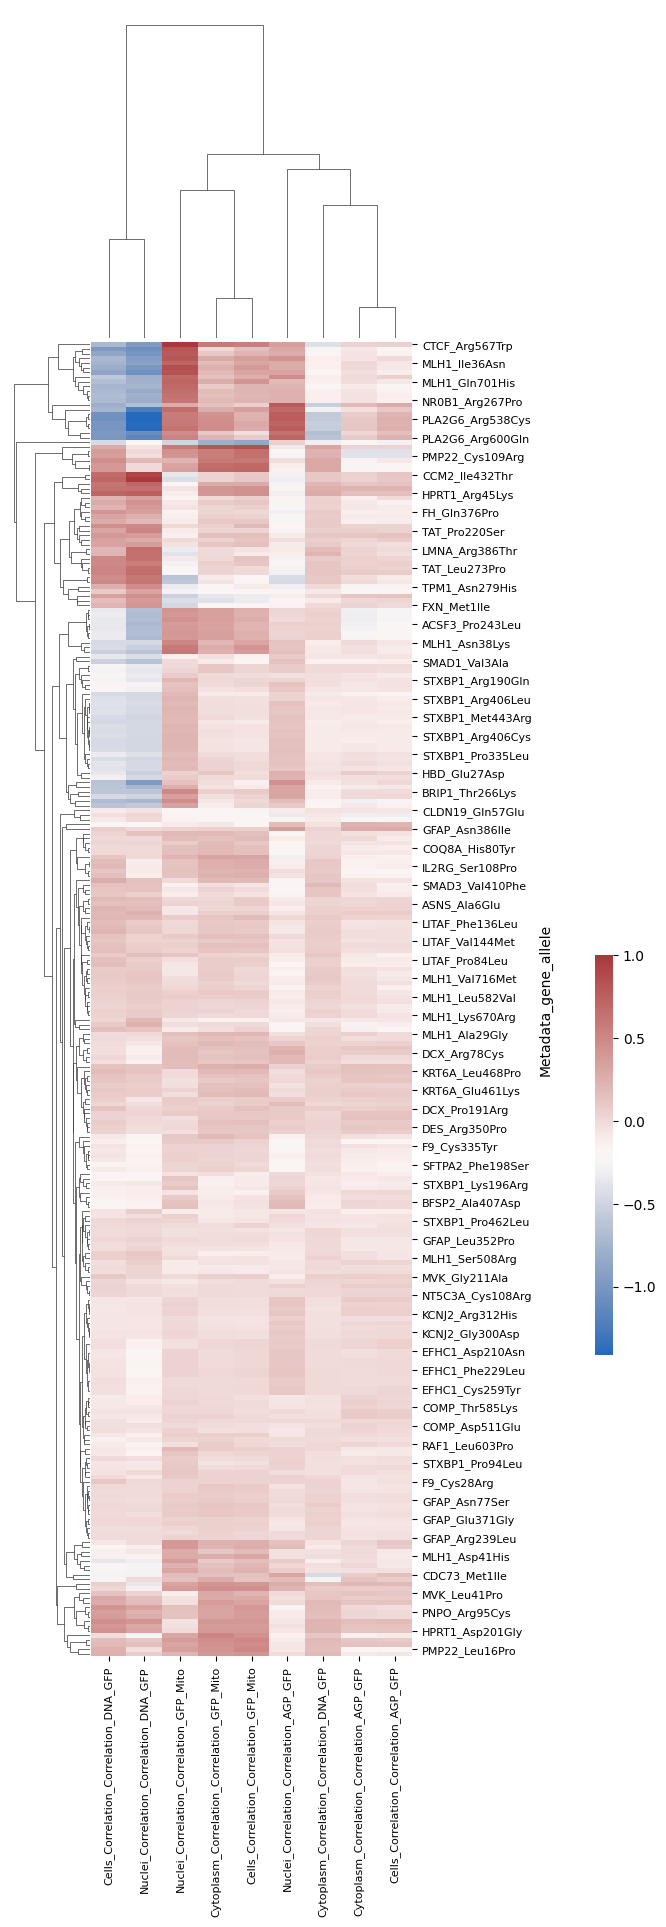

In [65]:
plt.clf()
g = sns.clustermap(misloc_variant_corr_diff_df.drop("Metadata_gene",axis=1), # .loc[pd.Index(gfap_alleles),col_stds_sig.index].T 
                   cmap="vlag", col_cluster=True, row_cluster=True, figsize=(6, 20), cbar_pos=(1., .32, .03, .2))
# Change tick label font sizes
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=8, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=8)

# Optional: Change colorbar font size
g.cax.tick_params(labelsize=10)
plt.show()

<Figure size 640x480 with 0 Axes>

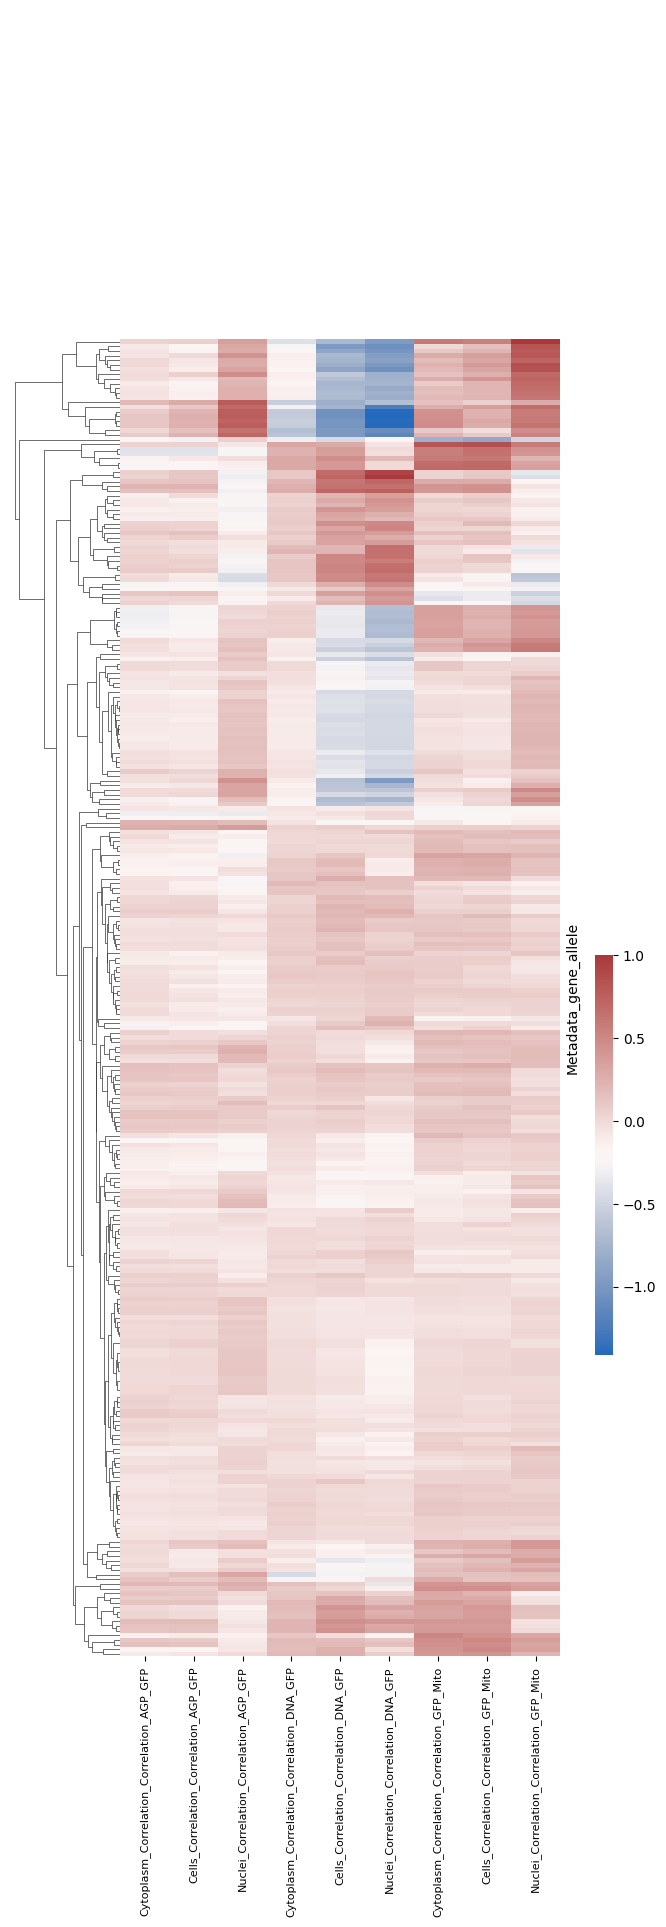

In [66]:
plt.clf()
g = sns.clustermap(misloc_variant_corr_diff_df[sorted(misloc_variant_corr_diff_df.columns, key=lambda x: x.split("_")[-2])].drop("Metadata_gene",axis=1), # .loc[pd.Index(gfap_alleles),col_stds_sig.index].T 
                   cmap="vlag", col_cluster=False, row_cluster=True, figsize=(6, 20), cbar_pos=(1., .32, .03, .2), yticklabels=0)
# Change tick label font sizes
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=8, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=8)
rows_to_label = [idx for idx in misloc_variant_corr_diff_df.index if "RHO" in idx]

# # Get y-axis tick positions after clustering
# tick_labels = g.ax_heatmap.get_yticklabels()
# tick_pos = g.ax_heatmap.get_yticks()
# # Map label to y-tick position
# label_pos_dict = {
#     tick.get_text(): pos 
#     for tick, pos in zip(tick_labels, tick_pos)
# }
# print(label_pos_dict)
# # Add labels only for selected rows
# texts = []
# for label in rows_to_label:
#     if label in label_pos_dict:
#         y = label_pos_dict[label]
#         texts.append(g.ax_heatmap.text(
#             x=misloc_variant_corr_diff_df[sorted(misloc_variant_corr_diff_df.columns, key=lambda x: x.split("_")[-2])].drop("Metadata_gene",axis=1).shape[1] + 0.2,  # to the right of the heatmap
#             y=y,
#             s=label,
#             va='center',
#             fontsize=10,
#             color='black'
#         ))
# Adjust text to prevent overlap
# adjust_text(texts, ax=g.ax_heatmap, only_move={'points': 'y', 'texts': 'y'})

# Optional: Change colorbar font size
# g.cax.tick_params(labelsize=10)

plt.show()

<Figure size 640x480 with 0 Axes>

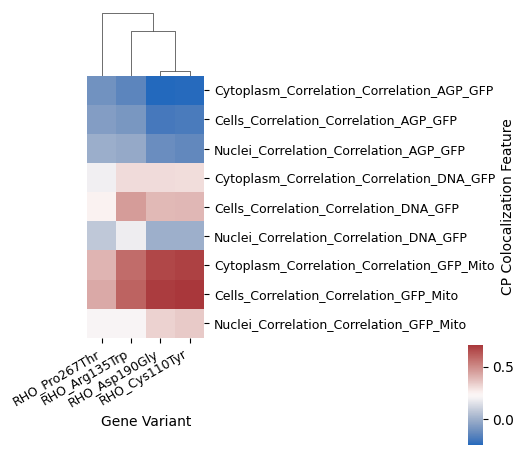

In [67]:
plt.clf()
rows_to_label = [idx for idx in misloc_variant_corr_diff_df.index if "RHO" in idx]
g = sns.clustermap(misloc_variant_corr_diff_df.loc[rows_to_label, sorted(misloc_variant_corr_diff_df.columns, key=lambda x: x.split("_")[-2])].drop("Metadata_gene",axis=1).T, # .loc[pd.Index(gfap_alleles),col_stds_sig.index].T 
                   cmap="vlag", col_cluster=True, row_cluster=False, figsize=(5, 5), cbar_pos=(.85, .1, .03, .2), yticklabels=1)
# Change tick label font sizes
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9, rotation=30, ha="right")
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
g.ax_heatmap.set_xlabel("Gene Variant", fontsize=10)
g.ax_heatmap.set_ylabel("CP Colocalization Feature", fontsize=10)
plt.show()

In [68]:
ref_var_allele_gfp_profile_df = int_num_cols(ref_var_allele_gfp_profile_df)

misloc_variant_gfp_feat_diff_df = pd.DataFrame()
for misloc_gene in misloc_genes:
    # fig, axes = plt.subplots(1,1,figsize=(6,5))
    # sns.boxenplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", saturation=.3, ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # sns.swarmplot(data=change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas(), 
    #               x="clinvar_clnsig_clean", y="AUROC_Mean", ax=axes,
    #             order=sorted(change_wtvar["localization"].join(clin_var_scores, on="allele_0").filter(pl.col("allele_0").str.contains(misloc_gene)).to_pandas()["clinvar_clnsig_clean"].unique()))
    # axes.set_title(misloc_gene)

    ref_var_allele_gfp_profile_df_gene = ref_var_allele_gfp_profile_df.filter(pl.col("Metadata_gene_allele").str.contains(misloc_gene)).to_pandas()

    misloc_allele_gfp_profile_wt = ref_var_allele_gfp_profile_df_gene[~ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    # gene_allele_gfp_profile_var = ref_var_allele_gfp_profile_df_gene[ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_")].copy()
    misloc_allele_gfp_profile_var = ref_var_allele_gfp_profile_df_gene[(ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_"))&\
                                                                        ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].isin(
                                                                          change_wtvar["localization"].filter((pl.col(f"Altered_local_both_batches")))["allele_0"]
                                                                        )].copy().set_index("Metadata_gene_allele")
    # display(misloc_allele_gfp_profile_wt)
    # display(misloc_allele_gfp_profile_var)
    if (misloc_allele_gfp_profile_wt.shape[0]>0):
        misloc_allele_var_minus_wt = misloc_allele_gfp_profile_var - misloc_allele_gfp_profile_wt.loc[misloc_gene]
    else:
        # display(misloc_allele_gfp_profile_wt)
        # display(misloc_allele_gfp_profile_var)
        continue
    # misloc_allele_gfp_profile_var_diff = misloc_allele_gfp_profile_var.subtract(misloc_allele_gfp_profile_wt, axis=1)
    # display(misloc_allele_gfp_profile_var_diff)
    # break
    # misloc_allele_gfp_profile_var["Gene"] = misloc_allele_gfp_profile_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

    # misloc_allele_var_minus_wt = pd.DataFrame()
    # try:
    #     for gene, group in misloc_allele_gfp_profile_var.groupby("Gene"):
    #         # print(gene)
    #         # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
    #         group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
    #         # display(group)
    #         group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
    #         # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
    # misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
    #         # display(misloc_allele_var_minus_wt)
    # except:
    #     continue
    # # display(misloc_allele_var_minus_wt)
    # # print(misloc_allele_var_minus_wt.shape[0])
    # # print(misloc_allele_var_minus_wt.shape[0])
    misloc_variant_gfp_feat_diff_df = pd.concat([misloc_variant_gfp_feat_diff_df, misloc_allele_var_minus_wt])

<Figure size 640x480 with 0 Axes>

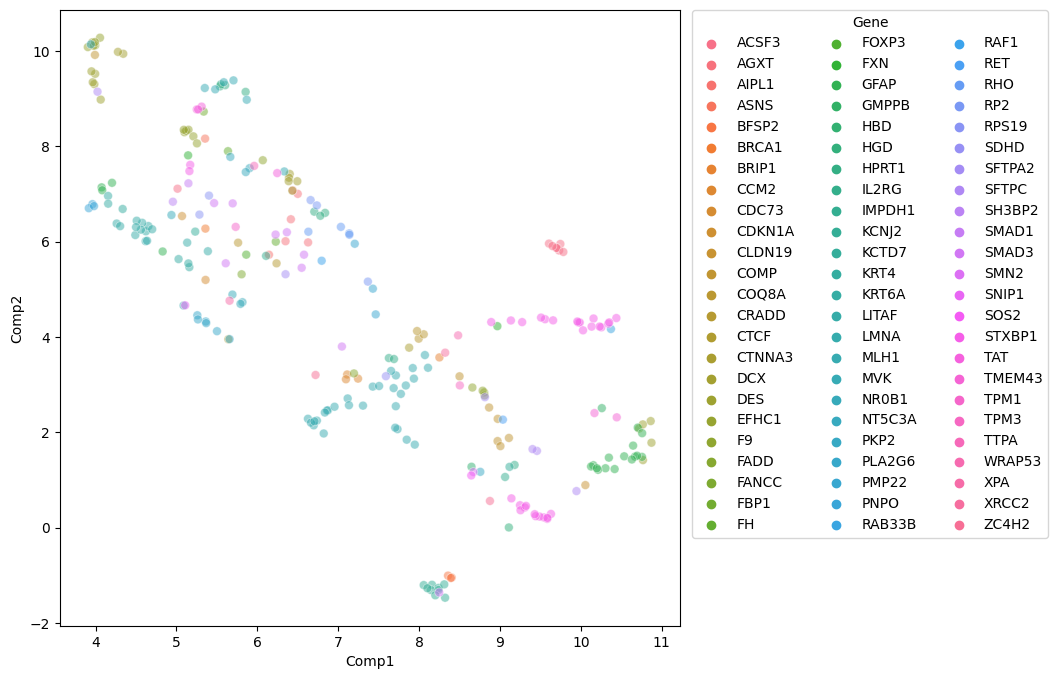

In [69]:
misloc_variant_gfp_feat_diff_df["Metadata_gene"] = [idx.split("_")[0] for idx in misloc_variant_gfp_feat_diff_df.index]
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8,8))
misloc_variant_gfp_diff_umap = plot_dr(pl.DataFrame(misloc_variant_gfp_feat_diff_df), "umap", 
                                       dr_args={"random_state":42, "n_jobs":1}, plot_args={"hue": "Metadata_gene"}, ax=ax)
ax.legend(ncol=3, title="Gene",
             loc="upper left",
             bbox_to_anchor=(1.02, 1.0),
             borderaxespad=0)
plt.show()

In [70]:
# misloc_variant_gfp_diff_umap[(misloc_variant_gfp_diff_umap["Comp1"]>8)&(misloc_variant_gfp_diff_umap["Comp2"]<4)]
# misloc_variant_gfp_diff_umap[misloc_variant_gfp_diff_umap["Comp1"]>12]
# misloc_variant_gfp_diff_umap[(misloc_variant_gfp_diff_umap["Comp1"]>4)&(misloc_variant_gfp_diff_umap["Comp2"]<4.5)]

<Figure size 640x480 with 0 Axes>

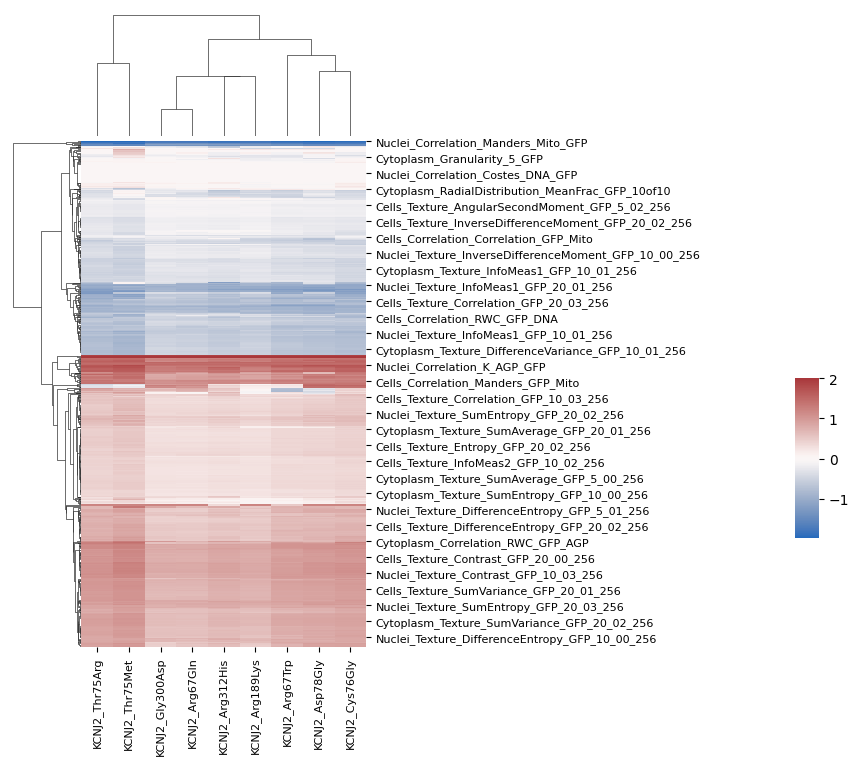

In [72]:
# sns.clustermap(misloc_variant_no_corr_diff_df)
gfap_alleles = [x for x in misloc_variant_gfp_feat_diff_df.index if "KCNJ2" in x]
# col_stds = misloc_variant_no_corr_diff_df.loc[pd.Index(gfap_alleles),].drop("Metadata_gene",axis=1).std()
# col_stds_sig = col_stds[col_stds>10]

plt.clf()
g = sns.clustermap(misloc_variant_gfp_feat_diff_df.loc[pd.Index(gfap_alleles),].drop(["Metadata_gene"],axis=1).T, 
                   cmap="vlag", col_cluster=True, row_cluster=True, figsize=(8, 8), cbar_pos=(1., .32, .03, .2))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=8, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=8)
plt.show()

<Figure size 640x480 with 0 Axes>

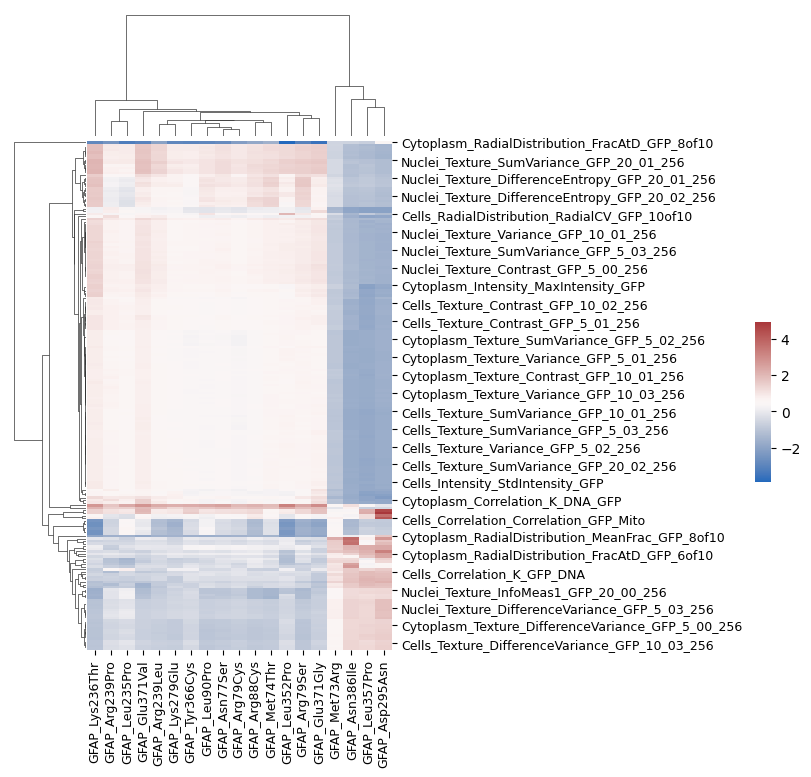

In [73]:
# sns.clustermap(misloc_variant_no_corr_diff_df)
gfap_alleles = [x for x in misloc_variant_gfp_feat_diff_df.index if "GFAP" in x]
col_stds = misloc_variant_gfp_feat_diff_df.loc[pd.Index(gfap_alleles),].drop(["Metadata_gene"],axis=1).std()
col_stds_sig = col_stds[col_stds>.8]
plt.clf()
g = sns.clustermap(misloc_variant_gfp_feat_diff_df.loc[pd.Index(gfap_alleles),col_stds_sig.index].T, 
                   cmap="vlag", col_cluster=True, row_cluster=True, figsize=(8, 8), cbar_pos=(.95, .39, .02, .2))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
plt.show()

In [74]:
misloc_variant_gfp_feat_diff_df["Metadata_gene"] = [x.split("_")[0] for x in misloc_variant_gfp_feat_diff_df.index]
misloc_variant_gfp_feat_diff_df["Metadata_gene_allele"] = [x for x in misloc_variant_gfp_feat_diff_df.index]
misloc_variant_gfp_feat_diff_df

Cytoplasm_Correlation_Correlation_AGP_GFP  \
Metadata_gene_allele                                              
KCTD7_Arg94Trp                                         0.472277   
KCTD7_Asn273Ile                                        2.479967   
HPRT1_Asp177Tyr                                        1.182509   
HPRT1_Gly70Glu                                         1.217910   
HPRT1_Phe74Leu                                         1.663071   
...                                                         ...   
PLA2G6_Glu567Lys                                       0.980687   
PLA2G6_Arg538Cys                                       0.922575   
PLA2G6_Arg600Gln                                       0.768296   
RPS19_Val15Phe                                         0.316741   
RPS19_Gly127Glu                                       -0.093406   

                      Cytoplasm_Correlation_Correlation_DNA_GFP  \
Metadata_gene_allele                                              
KCTD7_Arg94Trp                                         0.918230   
KCTD7_Asn273Ile                                       -0.897550   
HPRT1_Asp177Tyr                                        2.132637   
HPRT1_Gly70Glu                                         2.374964   
HPRT1_Phe74Leu                                         2.455436   
...                                                         ...   
PLA2G6_Glu567Lys                                      -2.544668   
PLA2G6_Arg538Cys                                      -2.602675   
PLA2G6_Arg600Gln                                      -3.669290   
RPS19_Val15Phe                                        -0.138416   
RPS19_Gly127Glu                                       -0.387936   

                      Cytoplasm_Correlation_Correlation_GFP_Mito  \
Metadata_gene_allele                                               
KCTD7_Arg94Trp                                          0.119846   
KCTD7_Asn273Ile                                        -0.601880   
HPRT1_Asp177Tyr                                         1.899951   
HPRT1_Gly70Glu                                          1.843646   
HPRT1_Phe74Leu                                          2.069204   
...                                                          ...   
PLA2G6_Glu567Lys                                        2.587050   
PLA2G6_Arg538Cys                                        2.496191   
PLA2G6_Arg600Gln                                        0.908044   
RPS19_Val15Phe                                          1.687185   
RPS19_Gly127Glu                                         1.543121   

                      Cytoplasm_Correlation_Costes_AGP_GFP  \
Metadata_gene_allele                                         
KCTD7_Arg94Trp                                    0.000000   
KCTD7_Asn273Ile                                   0.000000   
HPRT1_Asp177Tyr                                   0.000000   
HPRT1_Gly70Glu                                    0.000000   
HPRT1_Phe74Leu                                    0.000000   
...                                                    ...   
PLA2G6_Glu567Lys                                 -1.087339   
PLA2G6_Arg538Cys                                 -1.158069   
PLA2G6_Arg600Gln                                  0.000000   
RPS19_Val15Phe                                    0.000000   
RPS19_Gly127Glu                                   0.000000   

                      Cytoplasm_Correlation_Costes_DNA_GFP  \
Metadata_gene_allele                                         
KCTD7_Arg94Trp                                    0.000000   
KCTD7_Asn273Ile                                   0.000000   
HPRT1_Asp177Tyr                                   2.974375   
HPRT1_Gly70Glu                                    2.974375   
HPRT1_Phe74Leu                                    1.826417   
...                                                    ...   
PLA2G6_Glu567Lys                                 -1.064168   
PLA2G6_Arg538Cys            

In [77]:
umap_no_corr_df
misloc_variant_gfp_feat_diff_df

Cytoplasm_Correlation_Correlation_AGP_GFP  \
Metadata_gene_allele                                              
KCTD7_Arg94Trp                                         0.472277   
KCTD7_Asn273Ile                                        2.479967   
HPRT1_Asp177Tyr                                        1.182509   
HPRT1_Gly70Glu                                         1.217910   
HPRT1_Phe74Leu                                         1.663071   
...                                                         ...   
PLA2G6_Glu567Lys                                       0.980687   
PLA2G6_Arg538Cys                                       0.922575   
PLA2G6_Arg600Gln                                       0.768296   
RPS19_Val15Phe                                         0.316741   
RPS19_Gly127Glu                                       -0.093406   

                      Cytoplasm_Correlation_Correlation_DNA_GFP  \
Metadata_gene_allele                                              
KCTD7_Arg94Trp                                         0.918230   
KCTD7_Asn273Ile                                       -0.897550   
HPRT1_Asp177Tyr                                        2.132637   
HPRT1_Gly70Glu                                         2.374964   
HPRT1_Phe74Leu                                         2.455436   
...                                                         ...   
PLA2G6_Glu567Lys                                      -2.544668   
PLA2G6_Arg538Cys                                      -2.602675   
PLA2G6_Arg600Gln                                      -3.669290   
RPS19_Val15Phe                                        -0.138416   
RPS19_Gly127Glu                                       -0.387936   

                      Cytoplasm_Correlation_Correlation_GFP_Mito  \
Metadata_gene_allele                                               
KCTD7_Arg94Trp                                          0.119846   
KCTD7_Asn273Ile                                        -0.601880   
HPRT1_Asp177Tyr                                         1.899951   
HPRT1_Gly70Glu                                          1.843646   
HPRT1_Phe74Leu                                          2.069204   
...                                                          ...   
PLA2G6_Glu567Lys                                        2.587050   
PLA2G6_Arg538Cys                                        2.496191   
PLA2G6_Arg600Gln                                        0.908044   
RPS19_Val15Phe                                          1.687185   
RPS19_Gly127Glu                                         1.543121   

                      Cytoplasm_Correlation_Costes_AGP_GFP  \
Metadata_gene_allele                                         
KCTD7_Arg94Trp                                    0.000000   
KCTD7_Asn273Ile                                   0.000000   
HPRT1_Asp177Tyr                                   0.000000   
HPRT1_Gly70Glu                                    0.000000   
HPRT1_Phe74Leu                                    0.000000   
...                                                    ...   
PLA2G6_Glu567Lys                                 -1.087339   
PLA2G6_Arg538Cys                                 -1.158069   
PLA2G6_Arg600Gln                                  0.000000   
RPS19_Val15Phe                                    0.000000   
RPS19_Gly127Glu                                   0.000000   

                      Cytoplasm_Correlation_Costes_DNA_GFP  \
Metadata_gene_allele                                         
KCTD7_Arg94Trp                                    0.000000   
KCTD7_Asn273Ile                                   0.000000   
HPRT1_Asp177Tyr                                   2.974375   
HPRT1_Gly70Glu                                    2.974375   
HPRT1_Phe74Leu                                    1.826417   
...                                                    ...   
PLA2G6_Glu567Lys                                 -1.064168   
PLA2G6_Arg538Cys            

In [80]:
umap_no_corr_df

Comp1     Comp2 Metadata_gene
0    5.232026  6.210963         KCTD7
1    9.119071  1.275740         KCTD7
2    5.855189  9.142284         HPRT1
3    6.704659  6.629026         HPRT1
4    5.602379  9.282404         HPRT1
..        ...       ...           ...
277  5.265514  4.368379        PLA2G6
278  5.362568  4.326068        PLA2G6
279  5.501046  4.122163        PLA2G6
280  5.284108  6.567957         RPS19
281  5.402223  6.966902         RPS19

[282 rows x 3 columns]

<Figure size 640x480 with 0 Axes>

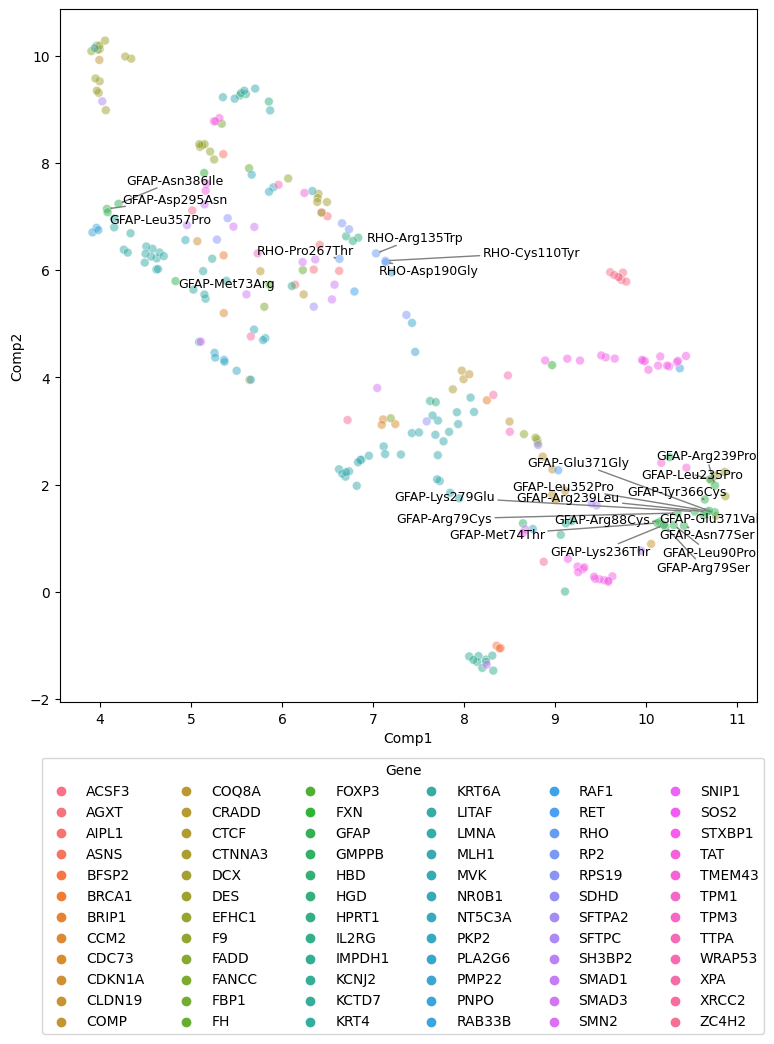

In [92]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(9,9))
umap_no_corr_df = plot_dr(pl.DataFrame(misloc_variant_gfp_feat_diff_df), "umap", dr_args={"random_state":42, "n_jobs": 1},
                          plot_args={"hue": "Metadata_gene"}, ax=ax)
umap_no_corr_df["Metadata_gene_allele"] = misloc_variant_gfp_feat_diff_df["Metadata_gene_allele"].values
ax.legend(ncol=6, title="Gene",
             loc="upper right",
             bbox_to_anchor=(1.01, -.08),
             borderaxespad=0)
from adjustText import adjust_text
# Add text labels with adjustText
texts = [
    plt.text(row['Comp1'], row['Comp2'], "-".join(row['Metadata_gene_allele'].split("_")), fontsize=9)
    for _, row in umap_no_corr_df.iterrows() if "GFAP" in row['Metadata_gene_allele'] or "RHO" in row['Metadata_gene_allele']
]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
plt.show()

In [222]:
all_genes = ref_var_allele_gfp_profile_df.with_columns(
    pl.col("Metadata_gene_allele").str.split("_").list.get(0).alias("gene_symbol")
)["gene_symbol"].unique()
all_variant_gfp_feat_diff_df = pd.DataFrame()
for gene in all_genes:
    ref_var_allele_gfp_profile_df_gene = ref_var_allele_gfp_profile_df.filter(pl.col("Metadata_gene_allele").str.contains(gene)).to_pandas()
    gene_allele_gfp_profile_wt = ref_var_allele_gfp_profile_df_gene[~ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    gene_allele_gfp_profile_var = ref_var_allele_gfp_profile_df_gene[ref_var_allele_gfp_profile_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")

    if (gene_allele_gfp_profile_wt.shape[0]>0):
        gene_allele_var_minus_wt = gene_allele_gfp_profile_var - gene_allele_gfp_profile_wt.loc[gene]
    else:
        # display(misloc_allele_gfp_profile_wt)
        # display(misloc_allele_gfp_profile_var)
        continue
    # misloc_allele_gfp_profile_var_diff = misloc_allele_gfp_profile_var.subtract(misloc_allele_gfp_profile_wt, axis=1)
    # display(misloc_allele_gfp_profile_var_diff)
    # break
    # misloc_allele_gfp_profile_var["Gene"] = misloc_allele_gfp_profile_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

    # misloc_allele_var_minus_wt = pd.DataFrame()
    # try:
    #     for gene, group in misloc_allele_gfp_profile_var.groupby("Gene"):
    #         # print(gene)
    #         # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
    #         group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
    #         # display(group)
    #         group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
    #         # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
    # misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
    #         # display(misloc_allele_var_minus_wt)
    # except:
    #     continue
    # # display(misloc_allele_var_minus_wt)
    # # print(misloc_allele_var_minus_wt.shape[0])
    # # print(misloc_allele_var_minus_wt.shape[0])
    all_variant_gfp_feat_diff_df = pd.concat([all_variant_gfp_feat_diff_df, gene_allele_var_minus_wt])

all_variant_gfp_feat_diff_df["Metadata_gene"] = [idx.split("_")[0] for idx in all_variant_gfp_feat_diff_df.index]

In [ ]:
color_map 

<Figure size 640x480 with 0 Axes>

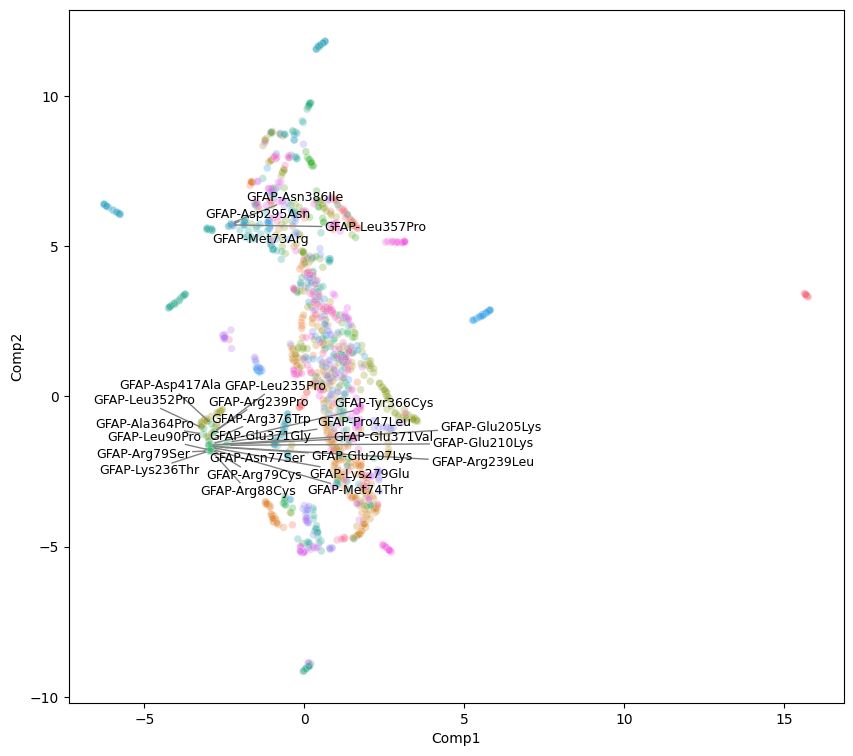

In [247]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(10,9))
umap_gfp_diff_df = plot_dr(pl.DataFrame(all_variant_gfp_feat_diff_df), "umap", dr_args={"random_state":42, "n_jobs": 1},
                          plot_args={"hue": "Metadata_gene","s": 30, "alpha": 0.3}, ax=ax)
umap_gfp_diff_df["Metadata_gene_allele"] = all_variant_gfp_feat_diff_df.index.values
ax.legend(ncol=10, title="Gene",
             loc="upper right",
             bbox_to_anchor=(1.02, -.08),
             borderaxespad=0)
ax.get_legend().remove()

from adjustText import adjust_text
# Add text labels with adjustText
texts = [
    plt.text(row['Comp1'], row['Comp2'], "-".join(row['Metadata_gene_allele'].split("_")), fontsize=9)
    for _, row in umap_gfp_diff_df.iterrows() if "GFAP" in row['Metadata_gene_allele']# or "RHO" in row['Metadata_gene_allele']
]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey'))
plt.show()

## 5. Morphology

In [198]:
altered_morph_vars = change_wtvar["morphology"].filter((pl.col("Altered_morph_both_batches"))).unique(subset="allele_0")["allele_0"]
altered_morph_genes = change_wtvar["morphology"].filter((pl.col("Altered_morph_both_batches"))).with_columns(
    pl.col("allele_0").str.split("_").list.get(0).alias("gene_symbol")
).unique(subset="gene_symbol")["gene_symbol"]

In [181]:
# ref_var_cell_morph_profile_df
change_wtvar["morphology"].filter(pl.col("Altered_morph_both_batches"))

shape: (20, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_m ┆ Altered_m ┆ Altered_m ┆ … ┆ Altered_m ┆ Altered_m ┆ AUROC_bat ┆ AUROC_ba │
│ ---       ┆ orph_batc ┆ orph_batc ┆ orph_both ┆   ┆ orph_batc ┆ orph_batc ┆ ch16      ┆ tch15    │
│ str       ┆ h12       ┆ h11       ┆ _batches  ┆   ┆ h16       ┆ h15       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ STXBP1_Ly ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ s196Arg   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_As ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ p207Asn   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_Pr ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ o335Leu   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_Gl ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ y544Asp   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ STXBP1_Ar ┆ 1         ┆ 1         ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ g406Cys   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Phe ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 558Ser    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_His ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 299Tyr    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Asn ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 132Lys    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Met ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 548Ile    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Arg ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 71Lys     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_His ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 239Arg    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRAF_Val4 ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 71Phe     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Ser ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 186Tyr    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Ser ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 611Arg    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRAF_Gly5 ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 96Val     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Pro ┆ null      ┆ null      ┆ true      ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│ 510Ser    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ BRCA1_Thr ┆ null      ┆ null      ┆ true   

In [146]:
ref_var_allele_morph_prof_df = (
    ref_var_cell_morph_profile_df.group_by(["Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in ref_var_cell_morph_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)
ref_var_allele_morph_prof_df = int_num_cols(ref_var_allele_morph_prof_df)

In [147]:
ref_var_allele_morph_prof_df

shape: (958, 2_188)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Metadata_ ┆ Cytoplasm ┆ Cytoplasm ┆ Cytoplasm ┆ … ┆ Nuclei_Te ┆ Nuclei_Te ┆ Nuclei_Te ┆ Nuclei_T │
│ gene_alle ┆ _Correlat ┆ _Correlat ┆ _Correlat ┆   ┆ xture_Var ┆ xture_Var ┆ xture_Var ┆ exture_V │
│ le        ┆ ion_Corre ┆ ion_Corre ┆ ion_Corre ┆   ┆ iance_Mit ┆ iance_Mit ┆ iance_Mit ┆ ariance_ │
│ ---       ┆ lat…      ┆ lat…      ┆ lat…      ┆   ┆ o_5…      ┆ o_5…      ┆ o_5…      ┆ Mito_5…  │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ STXBP1_Ty ┆ -2.682524 ┆ -0.717833 ┆ -2.29174  ┆ … ┆ -1.307559 ┆ -1.295353 ┆ -1.295353 ┆ -1.30143 │
│ r411His   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ GFAP_Arg2 ┆ -2.29174  ┆ -1.916326 ┆ -2.090929 ┆ … ┆ 0.551312  ┆ 0.575848  ┆ 0.582035  ┆ 0.585138 │
│ 39Leu     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ SDHD_Val1 ┆ -1.488029 ┆ -2.4168   ┆ -1.18264  ┆ … ┆ -0.671209 ┆ -0.667935 ┆ -0.658155 ┆ -0.66793 │
│ 11Ile     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ F9_Ile136 ┆ -0.684377 ┆ -0.379128 ┆ -0.051044 ┆ … ┆ 0.459134  ┆ 0.503202  ┆ 0.488408  ┆ 0.467874 │
│ Thr       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ CTCF_Arg3 ┆ 0.07464   ┆ -1.177391 ┆ 0.12197   ┆ … ┆ 0.225612  ┆ 0.20152   ┆ 0.180202  ┆ 0.193515 │
│ 42Gly     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ ADA       ┆ -1.413121 ┆ -1.289322 ┆ -1.326241 ┆ … ┆ 0.899332  ┆ 0.919111  ┆ 0.911156  ┆ 0.895418 │
│ GFAP_Leu3 ┆ -1.968065 ┆ -2.682524 ┆ -2.114803 ┆ … ┆ 0.745187  ┆ 0.762569  ┆ 0.759075  ┆ 0.759075 │
│ 52Pro     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Asn ┆ 0.955651  ┆ 1.187922  ┆ 1.259847  ┆ … ┆ 1.581435  ┆ 1.563419  ┆ 1.581435  ┆ 1.572363 │
│ 318Ser    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ RAF1_Asp4 ┆ -0.114066 ┆ -0.040567 ┆ 0.560473  ┆ … ┆ -1.581435 ┆ -1.599979 ┆ -1.590638 ┆ -1.58143 │
│ 86Asn     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 5        │
│ PTPN11_As ┆ 0.721223  ┆ 1.161834  ┆ 0.236361  ┆ … ┆ 0.872217  ┆ 0.853236  ┆ 0.857008  ┆ 0.879898 │
│ p106Ala   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [204]:
misloc_variant_morph_diff_df = pd.DataFrame()
for misloc_gene in list(altered_morph_genes):
    # print(misloc_gene)
    ref_var_allele_morph_prof_df_gene = ref_var_allele_morph_prof_df.filter(pl.col("Metadata_gene_allele").str.contains(misloc_gene)).to_pandas()

    misloc_allele_morph_prof_wt = ref_var_allele_morph_prof_df_gene[~ref_var_allele_morph_prof_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    misloc_allele_morph_prof_var = ref_var_allele_morph_prof_df_gene[ref_var_allele_morph_prof_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    # misloc_allele_morph_prof_var = ref_var_allele_morph_prof_df_gene[(ref_var_allele_morph_prof_df_gene["Metadata_gene_allele"].str.contains("_"))&\
    #                                                                   ref_var_allele_morph_prof_df_gene["Metadata_gene_allele"].isin(
    #                                                                       change_wtvar["morphology"].filter((pl.col(f"Altered_morph_both_batches")))["allele_0"]
    #                                                                   )].copy().set_index("Metadata_gene_allele")
    if (misloc_allele_morph_prof_wt.shape[0]>0):
        misloc_allele_morph_var_minus_wt = misloc_allele_morph_prof_var - misloc_allele_morph_prof_wt.loc[misloc_gene]
    else:
        # display(misloc_allele_gfp_profile_wt)
        # display(misloc_allele_gfp_profile_var)
        continue
    misloc_variant_morph_diff_df = pd.concat([misloc_variant_morph_diff_df, misloc_allele_morph_var_minus_wt])

misloc_variant_morph_diff_df["Metadata_gene"] = [idx.split("_")[0] for idx in misloc_variant_morph_diff_df.index]
# pl.Config.set_tbl_rows(50)  # Sets the number of rows displayed
change_wtvar["morphology"].filter(pl.col("allele_0").str.contains("KCNJ2")).unique("allele_0").sort(by="AUROC_Mean")

shape: (38, 15)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_m ┆ Altered_m ┆ Altered_m ┆ … ┆ Altered_m ┆ Altered_m ┆ AUROC_bat ┆ AUROC_ba │
│ ---       ┆ orph_batc ┆ orph_batc ┆ orph_both ┆   ┆ orph_batc ┆ orph_batc ┆ ch16      ┆ tch15    │
│ str       ┆ h12       ┆ h11       ┆ _batches  ┆   ┆ h16       ┆ h15       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ i64       ┆ i64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ KCNJ2_Gly ┆ null      ┆ null      ┆ null      ┆ … ┆ null      ┆ 1         ┆ null      ┆ 0.996587 │
│ 206Ser    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Val ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.469511  ┆ 0.594838 │
│ 93Ile     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Met ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.548636  ┆ 0.640624 │
│ 301Val    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Thr ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.679158  ┆ 0.615387 │
│ 400Met    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Asp ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.654369  ┆ 0.697663 │
│ 78Gly     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Gly ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.610446  ┆ 0.821284 │
│ 215Asp    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Val ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.848979  ┆ 0.657428 │
│ 302Met    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Arg ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.785093  ┆ 0.752551 │
│ 67Trp     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Arg ┆ null      ┆ null      ┆ false     ┆ … ┆ 1         ┆ 0         ┆ 0.90702   ┆ 0.651181 │
│ 82Gln     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Gly ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.814853  ┆ 0.771343 │
│ 300Asp    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Glu ┆ null      ┆ null      ┆ false     ┆ … ┆ 1         ┆ 0         ┆ 0.956412  ┆ 0.638306 │
│ 17Arg     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Thr ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.817103  ┆ 0.777675 │
│ 75Met     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Met ┆ null      ┆ null      ┆ false     ┆ … ┆ 1         ┆ 0         ┆ 0.894276  ┆ 0.742748 │
│ 301Leu    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Thr ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.737999  ┆ 0.902298 │
│ 75Arg     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Tyr ┆ null      ┆ null      ┆ false     ┆ … ┆ 1         ┆ 0         ┆ 0.894644  ┆ 0.760393 │
│ 326Asn    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Arg ┆ null      ┆ null      ┆ false     ┆ … ┆ 0         ┆ 0         ┆ 0.847951  ┆ 0.839197 │
│ 189Lys    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ KCNJ2_Cys ┆ null      ┆ null      ┆ false  

In [205]:
# brca_allele_morph_chg = dict(zip(
#     change_wtvar["morphology"].filter(pl.col("allele_0").str.contains("BRCA1")).unique("allele_0").sort(by="AUROC_Mean")["allele_0"].to_list(),
#     change_wtvar["morphology"].filter(pl.col("allele_0").str.contains("BRCA1")).unique("allele_0").sort(by="AUROC_Mean")["Altered_morph_both_batches"].to_list(),
# ))

<Figure size 640x480 with 0 Axes>

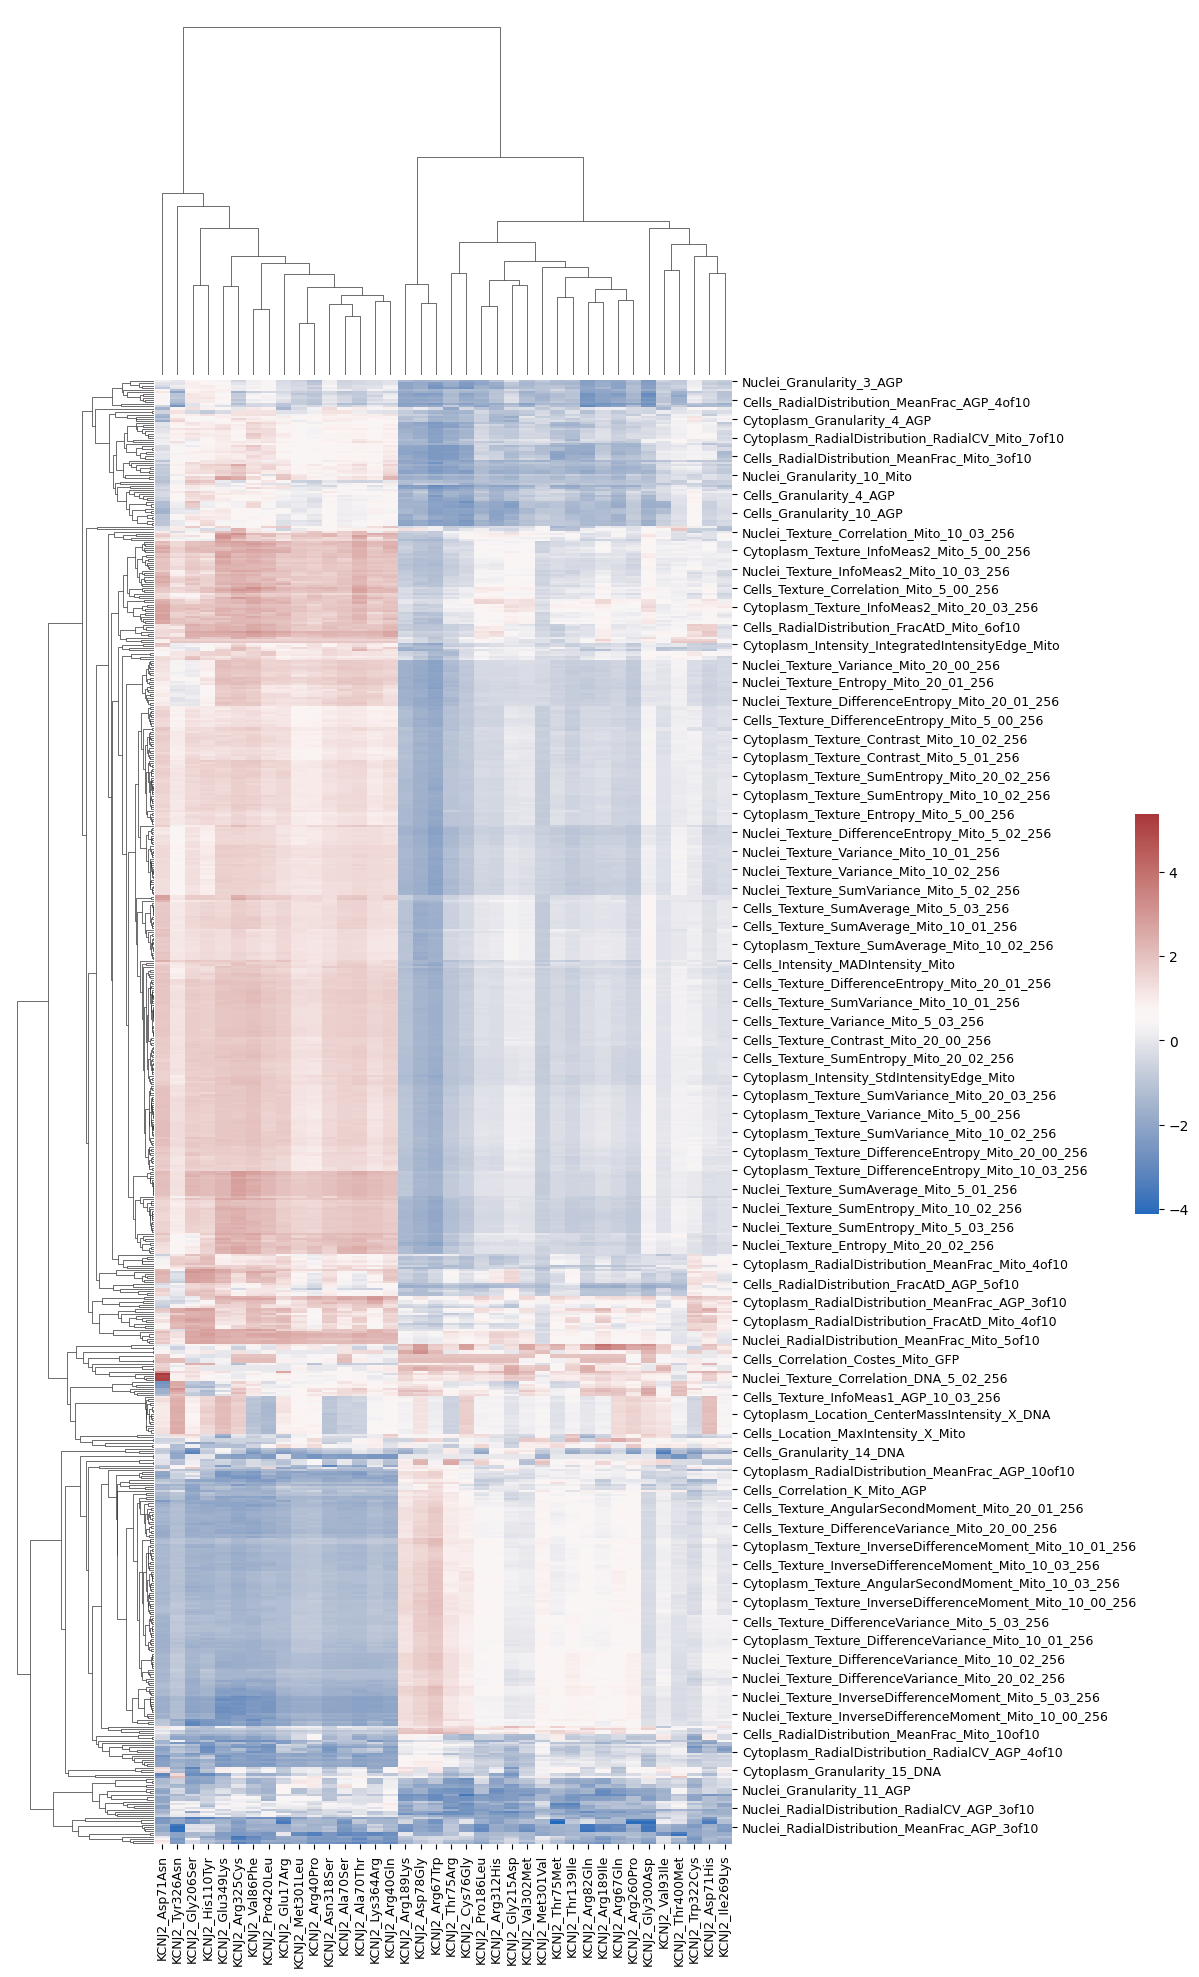

In [275]:
# sns.clustermap(misloc_variant_no_corr_diff_df)
brca1_alleles = change_wtvar["morphology"].filter(pl.col("allele_0").str.contains("KCNJ2")).unique("allele_0").sort(by="AUROC_Mean")["allele_0"].to_list()
col_stds = misloc_variant_morph_diff_df.loc[pd.Index(brca1_alleles),].drop(["Metadata_gene"],axis=1).std()
col_stds_sig = col_stds[col_stds>.8]
plt.clf()
cluster_map_brca1 = misloc_variant_morph_diff_df.loc[pd.Index(brca1_alleles),col_stds_sig.index]#.T
cluster_map_brca1_colors = pd.Series(brca_allele_morph_chg)
g = sns.clustermap(cluster_map_brca1.T, cmap="vlag", col_cluster=True, row_cluster=True, figsize=(12, 20), cbar_pos=(.95, .39, .02, .2), 
                   ) # col_colors=cluster_map_brca1_colors.map({True:'#E69F00', False:'#56B4E9', 'MITO':'#009E73'})
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=9, rotation=90)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=9)
plt.show()

In [287]:
cluster_map_brca1.std().sort_values()

Cytoplasm_Correlation_K_Mito_AGP                    0.800298
Cells_Granularity_6_Mito                            0.800833
Cytoplasm_Correlation_Costes_GFP_Mito               0.800874
Nuclei_RadialDistribution_FracAtD_Mito_10of10       0.801023
Cytoplasm_RadialDistribution_MeanFrac_AGP_1of10     0.801077
                                                      ...   
Cytoplasm_Granularity_9_Mito                        1.407693
Nuclei_Texture_AngularSecondMoment_Mito_5_00_256    1.415056
Nuclei_Texture_AngularSecondMoment_Mito_5_02_256    1.415810
Cytoplasm_Granularity_10_Mito                       1.420665
Nuclei_Granularity_1_Mito                           1.487894
Length: 702, dtype: float64

<Figure size 640x480 with 0 Axes>

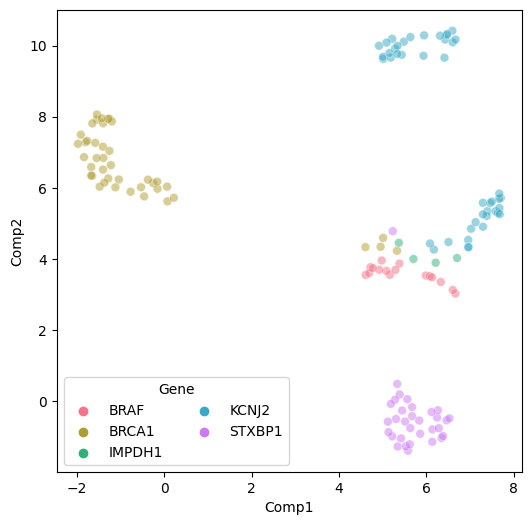

In [213]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(6,6))
umap_morph_allele_df = plot_dr(pl.DataFrame(misloc_variant_morph_diff_df), "umap", dr_args={"random_state":42, "n_jobs": 1},
                          plot_args={"hue": "Metadata_gene"}, ax=ax)
umap_morph_allele_df["Metadata_gene_allele"] = misloc_variant_morph_diff_df.index.values
ax.legend(ncol=2, title="Gene",
         loc="lower left",
         # bbox_to_anchor=(1.01, -.08),borderaxespad=0
         )

# from adjustText import adjust_text
# # Add text labels with adjustText
# texts = [
#     plt.text(row['Comp1'], row['Comp2'], "-".join(row['Metadata_gene_allele'].split("_")), fontsize=9)
#     for _, row in umap_morph_allele_df.iterrows() if "KCNJ2" in row['Metadata_gene_allele']
# ]
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
plt.show()

In [240]:
all_variant_morph_feat_diff_df = pd.DataFrame()

all_genes_morph = ref_var_allele_morph_prof_df.with_columns(
    pl.col("Metadata_gene_allele").str.split("_").list.get(0).alias("gene_symbol")
)["gene_symbol"].unique()

for gene in all_genes_morph:
    ref_var_allele_morph_prof_df_gene = ref_var_allele_morph_prof_df.filter(pl.col("Metadata_gene_allele").str.contains(gene)).to_pandas()
    gene_allele_morph_profile_wt = ref_var_allele_morph_prof_df_gene[~ref_var_allele_morph_prof_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
    gene_allele_morph_profile_var = ref_var_allele_morph_prof_df_gene[ref_var_allele_morph_prof_df_gene["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")

    if (gene_allele_morph_profile_wt.shape[0]>0):
        gene_allele_morph_var_minus_wt = gene_allele_morph_profile_var - gene_allele_morph_profile_wt.loc[gene]
    else:
        # display(misloc_allele_gfp_profile_wt)
        # display(misloc_allele_gfp_profile_var)
        continue
    # misloc_allele_gfp_profile_var_diff = misloc_allele_gfp_profile_var.subtract(misloc_allele_gfp_profile_wt, axis=1)
    # display(misloc_allele_gfp_profile_var_diff)
    # break
    # misloc_allele_gfp_profile_var["Gene"] = misloc_allele_gfp_profile_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

    # misloc_allele_var_minus_wt = pd.DataFrame()
    # try:
    #     for gene, group in misloc_allele_gfp_profile_var.groupby("Gene"):
    #         # print(gene)
    #         # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
    #         group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
    #         # display(group)
    #         group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
    #         # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
    # misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
    #         # display(misloc_allele_var_minus_wt)
    # except:
    #     continue
    # # display(misloc_allele_var_minus_wt)
    # # print(misloc_allele_var_minus_wt.shape[0])
    # # print(misloc_allele_var_minus_wt.shape[0])
    all_variant_morph_feat_diff_df = pd.concat([all_variant_morph_feat_diff_df, gene_allele_morph_var_minus_wt])

all_variant_morph_feat_diff_df["Metadata_gene"] = [idx.split("_")[0] for idx in all_variant_morph_feat_diff_df.index]

<Figure size 640x480 with 0 Axes>

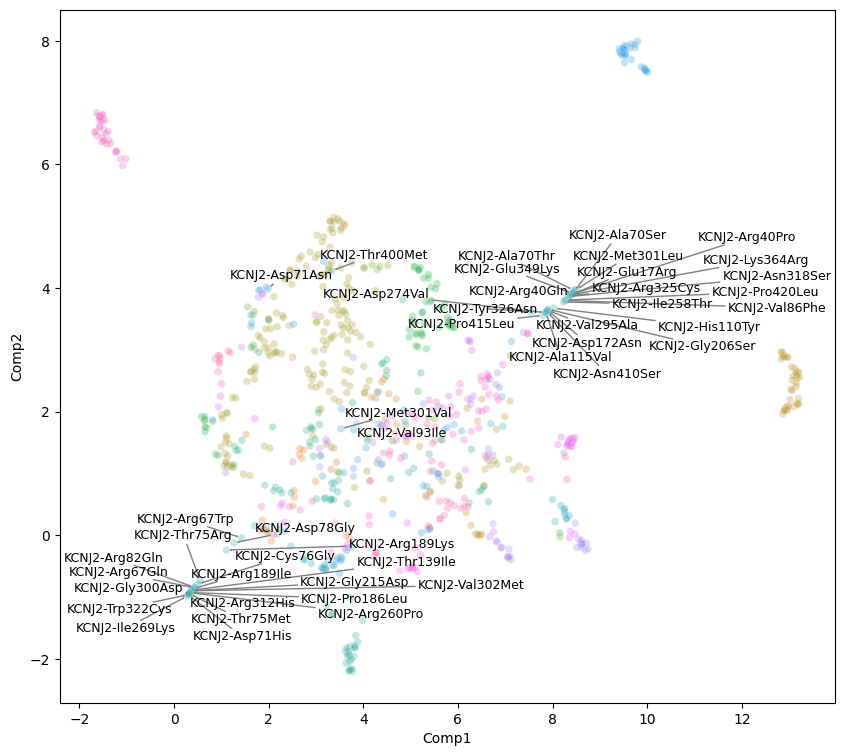

In [248]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(10,9))
umap_morph_all_allele_df = plot_dr(pl.DataFrame(all_variant_morph_feat_diff_df), "umap", dr_args={"random_state":42, "n_jobs": 1},
                          plot_args={"hue": "Metadata_gene","s": 30, "alpha": 0.3}, ax=ax)
umap_morph_all_allele_df["Metadata_gene_allele"] = all_variant_morph_feat_diff_df.index.values
ax.legend(ncol=2, title="Gene",
         loc="lower left",
         # bbox_to_anchor=(1.01, -.08),borderaxespad=0
         )
ax.get_legend().remove()

from adjustText import adjust_text
# Add text labels with adjustText
texts = [
    plt.text(row['Comp1'], row['Comp2'], "-".join(row['Metadata_gene_allele'].split("_")), fontsize=9)
    for _, row in umap_morph_all_allele_df.iterrows() if "KCNJ2" in row['Metadata_gene_allele']
]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))
plt.show()

In [297]:
cluster_map_brca1.std().sort_values().tail(200)

Cells_Texture_Contrast_Mito_20_01_256                   1.119037
Cells_Texture_InverseDifferenceMoment_Mito_20_02_256    1.119665
Nuclei_Texture_DifferenceEntropy_Mito_10_03_256         1.120061
Cells_Texture_SumEntropy_Mito_5_01_256                  1.120364
Cytoplasm_Intensity_MaxIntensityEdge_Mito               1.120550
                                                          ...   
Cytoplasm_Granularity_9_Mito                            1.407693
Nuclei_Texture_AngularSecondMoment_Mito_5_00_256        1.415056
Nuclei_Texture_AngularSecondMoment_Mito_5_02_256        1.415810
Cytoplasm_Granularity_10_Mito                           1.420665
Nuclei_Granularity_1_Mito                               1.487894
Length: 200, dtype: float64

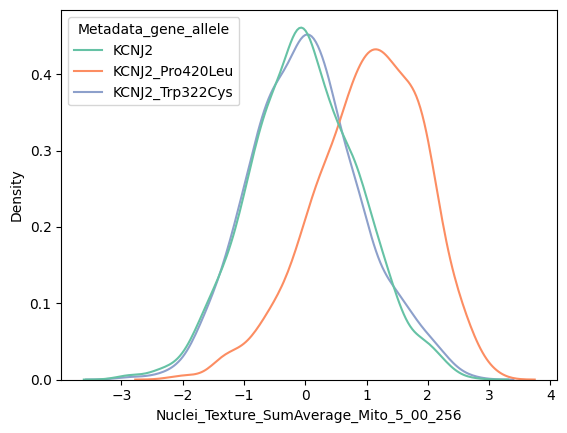

In [306]:
col_name = "Nuclei_Texture_SumAverage_Mito_5_00_256"
ref_var_cell_morph_prof_int_select_df = int_num_cols(ref_var_cell_morph_profile_df.select(
    pl.col([col_name]+[col for col in ref_var_cell_morph_profile_df.columns if "Metadata_" in col])
))

sns.kdeplot(data=ref_var_cell_morph_prof_int_select_df.filter(
        (pl.col("Metadata_gene_allele").str.contains("KCNJ2_Trp322"))|(pl.col("Metadata_gene_allele").str.contains("KCNJ2_Pro420Leu"))|(pl.col("Metadata_gene_allele")=="KCNJ2")
    ).with_columns(
        pl.when(pl.col("Metadata_gene_allele").str.contains("_"))
        .then(pl.lit("Var"))
        .otherwise(pl.lit("Ref"))
        .alias("Gene_Status")
    ).to_pandas(),
    x=col_name,
    hue="Metadata_gene_allele",
    common_norm=False,
    palette="Set2"
)
plt.show()

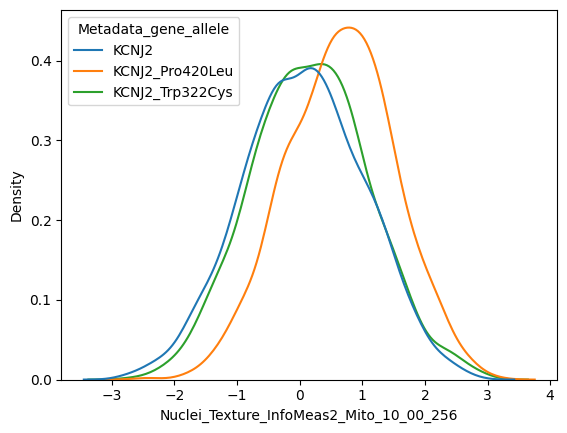

In [301]:
col_name = "Nuclei_Texture_InfoMeas2_Mito_10_00_256"
ref_var_cell_morph_prof_int_select_df = int_num_cols(ref_var_cell_morph_profile_df.select(
    pl.col([col_name]+[col for col in ref_var_cell_morph_profile_df.columns if "Metadata_" in col])
))

sns.kdeplot(data=ref_var_cell_morph_prof_int_select_df.filter(
        (pl.col("Metadata_gene_allele").str.contains("KCNJ2_Trp322"))|(pl.col("Metadata_gene_allele").str.contains("KCNJ2_Pro420Leu"))|(pl.col("Metadata_gene_allele")=="KCNJ2")
    ).with_columns(
        pl.when(pl.col("Metadata_gene_allele").str.contains("_"))
        .then(pl.lit("Var"))
        .otherwise(pl.lit("Ref"))
        .alias("Gene_Status")
    ).to_pandas(),
    x=col_name,
    hue="Metadata_gene_allele",
    common_norm=False
)
plt.show()

In [268]:
ref_var_cell_morph_profile_df.select(pl.col([x for x in ref_var_cell_morph_profile_df.columns if x.startswith("Cells_Texture_InfoMeas")])).std()#>10#.transpose()

shape: (1, 72)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Cells_Tex ┆ Cells_Tex ┆ Cells_Tex ┆ Cells_Tex ┆ … ┆ Cells_Tex ┆ Cells_Tex ┆ Cells_Tex ┆ Cells_Te │
│ ture_Info ┆ ture_Info ┆ ture_Info ┆ ture_Info ┆   ┆ ture_Info ┆ ture_Info ┆ ture_Info ┆ xture_In │
│ Meas1_AGP ┆ Meas1_AGP ┆ Meas1_AGP ┆ Meas1_AGP ┆   ┆ Meas2_Mit ┆ Meas2_Mit ┆ Meas2_Mit ┆ foMeas2_ │
│ _10…      ┆ _10…      ┆ _10…      ┆ _10…      ┆   ┆ o_5…      ┆ o_5…      ┆ o_5…      ┆ Mito_5…  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.041334  ┆ 0.030025  ┆ 0.041042  ┆ 0.030062  ┆ … ┆ 0.079253  ┆ 0.104014  ┆ 0.079836  ┆ 0.10443  │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘